导入所需包

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import geopandas as gpd

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

导入数据

In [3]:
path = '../raw_data/LB9LC30F5KALA6562.csv'
raw_data = pd.read_csv(path, low_memory=False)

简单观察raw_data字段信息

In [4]:
print(raw_data.shape)
print(raw_data.columns)

(458131, 89)
Index(['VIN', '消息类型', '数据采集时间', '车辆状态', '充电状态', '运行模式', '车速', '累计里程', '总电压',
       '总电流', 'SOC', 'DC-DC状态', '档位', '绝缘电阻', '驱动电机个数', '驱动电机序号', '驱动电机状态',
       '驱动电机控制器温度', '驱动电机转速', '驱动电机转矩', '驱动电机温度', '电机控制器输入电压', '电机控制器直流母线电流',
       '燃料电池电压', '燃料电池电流', '燃料电池燃料消耗率', '燃料电池温度探针总数', '燃料电池温度值', '氢系统中最高温度',
       '氢系统中最高温度探针号', '氢气最高浓度', '氢气最高浓度传感器代号', '氢气最高压力', '氢气最高压力传感器代号',
       '高压DC-DC状态', '发动机状态', '曲轴转速', '发动机燃料消耗率', '定位状态', '经度', '纬度',
       '最高电压电池子系统号', '最高电压电池单体代号', '电池单体电压最高值', '最低电压电池子系统号', '最低电压电池单体代号',
       '电池单体电压最低值', '最高温度子系统号', '最高温度探针号', '最高温度值', '最低温度子系统号', '最低温度探针号',
       '最低温度值', '最高报警等级', '通用报警标志', '温度差异报警', '电池高温报警', '车载储能装置类型过压报警',
       '车载储能装置类型欠压报警', 'SOC低报警', '单体电池过压报警', '单体电池欠压报警', 'SOC过高报警', 'SOC跳变报警',
       '可充电储能系统不匹配报警', '电池单体一致性差报警', '绝缘报警', 'DC-DC温度报警', '制动系统报警',
       'DC-DC状态报警', '驱动电机控制器温度报警', '高压互锁状态报警', '驱动电机温度报警', '车载储能装置类型过充',
       '报警标志位解析', '可充电储能装置故障总数N1', '可充电储能装置故障代码列表', '驱动电机故障总数N2', '驱动电机故障代码列表',
       '发动机故障总数

# 1.EDA(列处理)

## 1.1.删除全为空的列

In [5]:
deal_data = raw_data.dropna(axis=1, how='all')
print(deal_data.shape)

(458131, 49)


## 1.2.删除内部数据值完全相同的列

In [6]:
same_col = []
same_col_dict = {}

for col in deal_data.columns:
    if len(deal_data[col].unique()) == 1:
        print(col, deal_data[col].unique())
        same_col.append(col)
        same_col_dict[col] = list(deal_data[col].unique())
    else:
        pass

deal_data = deal_data.drop(same_col, axis=1)

print(deal_data.shape)
print(deal_data.columns)

VIN ['LB9LC30F5KALA6562']
运行模式 [1]
驱动电机个数 [1]
驱动电机序号 [' 1:1']
驱动电机故障总数N2 [0]
发动机故障总数N3 [0]
其他故障总数N4 [0]
单体电池(可充电储能子系统)总数 ["'"]
单体电池(可充电储能子系统)温度探针总数 ["'"]
(458131, 40)
Index(['消息类型', '数据采集时间', '车辆状态', '充电状态', '车速', '累计里程', '总电压', '总电流', 'SOC',
       'DC-DC状态', '档位', '绝缘电阻', '驱动电机状态', '驱动电机控制器温度', '驱动电机转速', '驱动电机转矩',
       '驱动电机温度', '电机控制器输入电压', '电机控制器直流母线电流', '定位状态', '经度', '纬度', '最高电压电池子系统号',
       '最高电压电池单体代号', '电池单体电压最高值', '最低电压电池子系统号', '最低电压电池单体代号', '电池单体电压最低值',
       '最高温度子系统号', '最高温度探针号', '最高温度值', '最低温度子系统号', '最低温度探针号', '最低温度值',
       '最高报警等级', '通用报警标志', '绝缘报警', '报警标志位解析', '可充电储能装置故障总数N1',
       '可充电储能装置故障代码列表'],
      dtype='object')


每个csv对应一辆车运行数据，6562运行模式为1代表纯电，驱动电机个数为1；仅出现绝缘报警。

## 1.3.时间处理

In [7]:
deal_data['time'] = deal_data['数据采集时间'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
del deal_data['数据采集时间']

In [8]:
deal_data.sort_values(by='time', inplace=True)

In [9]:
deal_data.reset_index(drop=True, inplace=True)

## 1.4.筛选有用特征

In [10]:
for col in deal_data.columns:
    if col != 'time':
        print(col,str(deal_data[col].dtype), deal_data[col].unique())

消息类型 int64 [2 3]
车辆状态 int64 [1 2]
充电状态 int64 [3 1 2 4]
车速 float64 [ 0. 20. 32. 17. 16.  4. 15. 33. 42. 46. 47. 38. 40. 50. 26. 49. 22.  5.
 51. 52. 35. 48. 21. 13. 45. 53. 18.  8.  7. 34. 39. 44. 31. 36. 37. 41.
 43. 30. 28. 23. 29. 54.  1. 12.  9.  6. 27. 10. 25.  2. 14. 11. 19.  3.
 24. 56. 55. 57. 58. 59. 61. 60. 62.]
累计里程 float64 [ 11019.6  11019.7  11019.8 ... 330716.7 330716.8 330717. ]
总电压 float64 [609.9 609.5 609.1 608.9 609.  608.7 608.6 608.5 606.5 597.8 604.4 604.1
 602.7 603.2 599.9 601.  599.3 597.9 599.5 596.1 595.1 598.3 590.3 595.4
 593.5 597.3 595.6 596.9 592.5 593.9 594.9 593.4 594.8 595.8 593.1 596.6
 596.8 597.4 588.4 593.3 594.4 594.2 595.  594.6 592.4 595.7 597.5 593.7
 596.7 595.2 593.  598.1 592.  594.5 594.3 590.9 598.7 597.2 594.  597.
 596.3 599.7 598.2 600.6 598.  595.9 591.5 592.8 594.7 592.9 591.1 591.6
 597.7 596.  598.5 589.7 597.6 593.8 601.9 592.3 601.4 592.7 596.2 593.6
 602.4 595.3 590.4 595.5 589.2 589.1 598.4 598.9 596.5 591.9 591.3 588.7
 593.2 58

### 最后有意义的信息
| 数据表示内容 | 描述及要求 | 备注 |
|:---:| :------|:----|
| 车辆状态 | 1：启动；2：熄火 |  |
| 充电状态 | 1：停车充电；2：行驶充电；<br>3：未充电；4：充电完成 |  |
| 车速 | 全为整数，0-65km/h | 原数据已处理 |
| 累计里程 |  | 原数据已处理 |
| 总电压 | 600V左右 | 原数据已处理 |
| 总电流 | -400A到400A | 原数据已处理 |
| SOC | 0-100% |  |
| 档位 | 为10进制数表示的8位2进制数 | 原数据已处理 |
| 绝缘电阻 | 0-50000KΩ |  |
| 电池单体电压最高值 | 均值3.3V | 原数据已处理 |
| 最高电压电池单体代号 | 电池代号1-180，出现频率差别很大 |  |
| 电池单体电压最低值 | 均值3.25V | 原数据已处理 |
| 最低电压电池单体代号 | 电池代号1-180，出现频率差别很大 |  |
| 最高温度子系统号 | 出现频率差别很大 |  |
| 最高温度值 |  |   |
| 最高温度探针号 | 探针号出现频率差别很大 |  |
| 最低温度子系统号 | 出现频率差别很大 |  |
| 最低温度值 |  |  |
| 最低温度探针号 | 探针号出现频率差别很大 |  |
| 经纬度及定位状态 | 定位状态1为无效定位 |  |
| 最高报警等级 | 故障代码0-3；0：无故障；1：1级故障，不影响车辆驾驶；2：2级故障，影响车辆性能，需驾驶员限制行驶；3：3级故障，驾驶员应立即停车或请求救援 |  |
| 通用报警标志 | 详见字段表18，由十进制数表示的多位二进制数，0：正常；2048：二进制数第11位为1，表示绝缘报警 | 报警标志位解析为绝缘报警，'绝缘报警''可充电储能装置故障总数N1''可充电储能装置故障代码列表'互相关联, 该绝缘报警与DC-DC状态无关 |
| 各种报警状态 | 出现对应报警则值为1，否则为nan |  |

这几列参数为形式为比值的字符串，例如'1:19'，需要处理成数值型数据，<br>冒号后面可能为处理过的数据，也可能为原始数据，需要进一步分析，先按照其为处理过的数据分析。
| 数据表示内容 | 描述及要求 | 备注 |
|:---:| :------|:----:|
| 驱动电机状态 | 1：耗电；2：发电；3：关闭 |  |
| 驱动电机控制器温度 | 全为整数，单位°C |  |
| 驱动电机转速 | 全为整数，单位r/min |  |
| 驱动电机转矩 | 单位Nm |  |
| 驱动电机温度 | 全为整数，单位°C |  |
| 电机控制器输入电压 | 单位V |  |
| 电机控制器直流母线电流 | 单位A |  |

## 1.5.处理字符串形式的比值数据和十进制表示的二进制数

In [11]:
deal_data['驱动电机状态'] = deal_data['驱动电机状态'].apply(lambda x: int(x.split(':')[1]))

In [12]:
strlist = ['驱动电机控制器温度','驱动电机转速','驱动电机转矩','驱动电机温度','电机控制器输入电压','电机控制器直流母线电流']
for str in strlist:
    deal_data[str] = deal_data[str].apply(lambda x: float(x.split(':')[1]))

In [13]:
deal_data['档位'] = deal_data['档位'].apply(lambda x:bin(x)[2:].zfill(8) )

# 2.EDA(行处理)

## 2.1.删除重复行

In [14]:
deal_data.drop_duplicates(subset=['time'], inplace=True)
deal_data.reset_index(drop=True, inplace=True)

过多重复行？

# 3.检查数据

In [15]:
import random

ylist=['累计里程','车速','车辆状态','充电状态','总电压','总电流','SOC',
    '驱动电机状态', '驱动电机转速','驱动电机转矩','驱动电机温度',
    '驱动电机控制器温度','电机控制器输入电压','电机控制器直流母线电流']

def plot_method_withtime(df, style):
    df = df.reset_index(drop = True)
    df.plot(kind=style, y=ylist, x='time', 
            legend=True,
            subplots=True, figsize=(48, 36))

def plot_data_withtime(data, num=25000, random_=False, style='line'):
    data = data.reset_index(drop = True)
    start = data.index.to_list()[0]
    end = data.index.to_list()[-1]

    if num < end - start:
        if random_ == True:
            n = random.randint(start, end-num)
        else:
            n = start
        sample = data.loc[n:n+num]
    else:
        sample = data[start:end]
    
    plot_method_withtime(sample, style)



def plot_method_notime(df,style):
    df = df.reset_index(drop = True)
    df.plot(kind=style, y=ylist, 
            subplots=True, figsize=(72, 54))

def plot_data_notime(data, num=25000, random_=False, style='line'):
    data = data.reset_index(drop = True)

    start = data.index.to_list()[0]
    end = data.index.to_list()[-1]

    if num < end - start:
        if random_ == True:
            n = random.randint(start, end-num)
        else:
            n = start
        sample = data.loc[n:n+num]
    else:
        sample = data[start:end]
    
    plot_method_notime(sample, style)

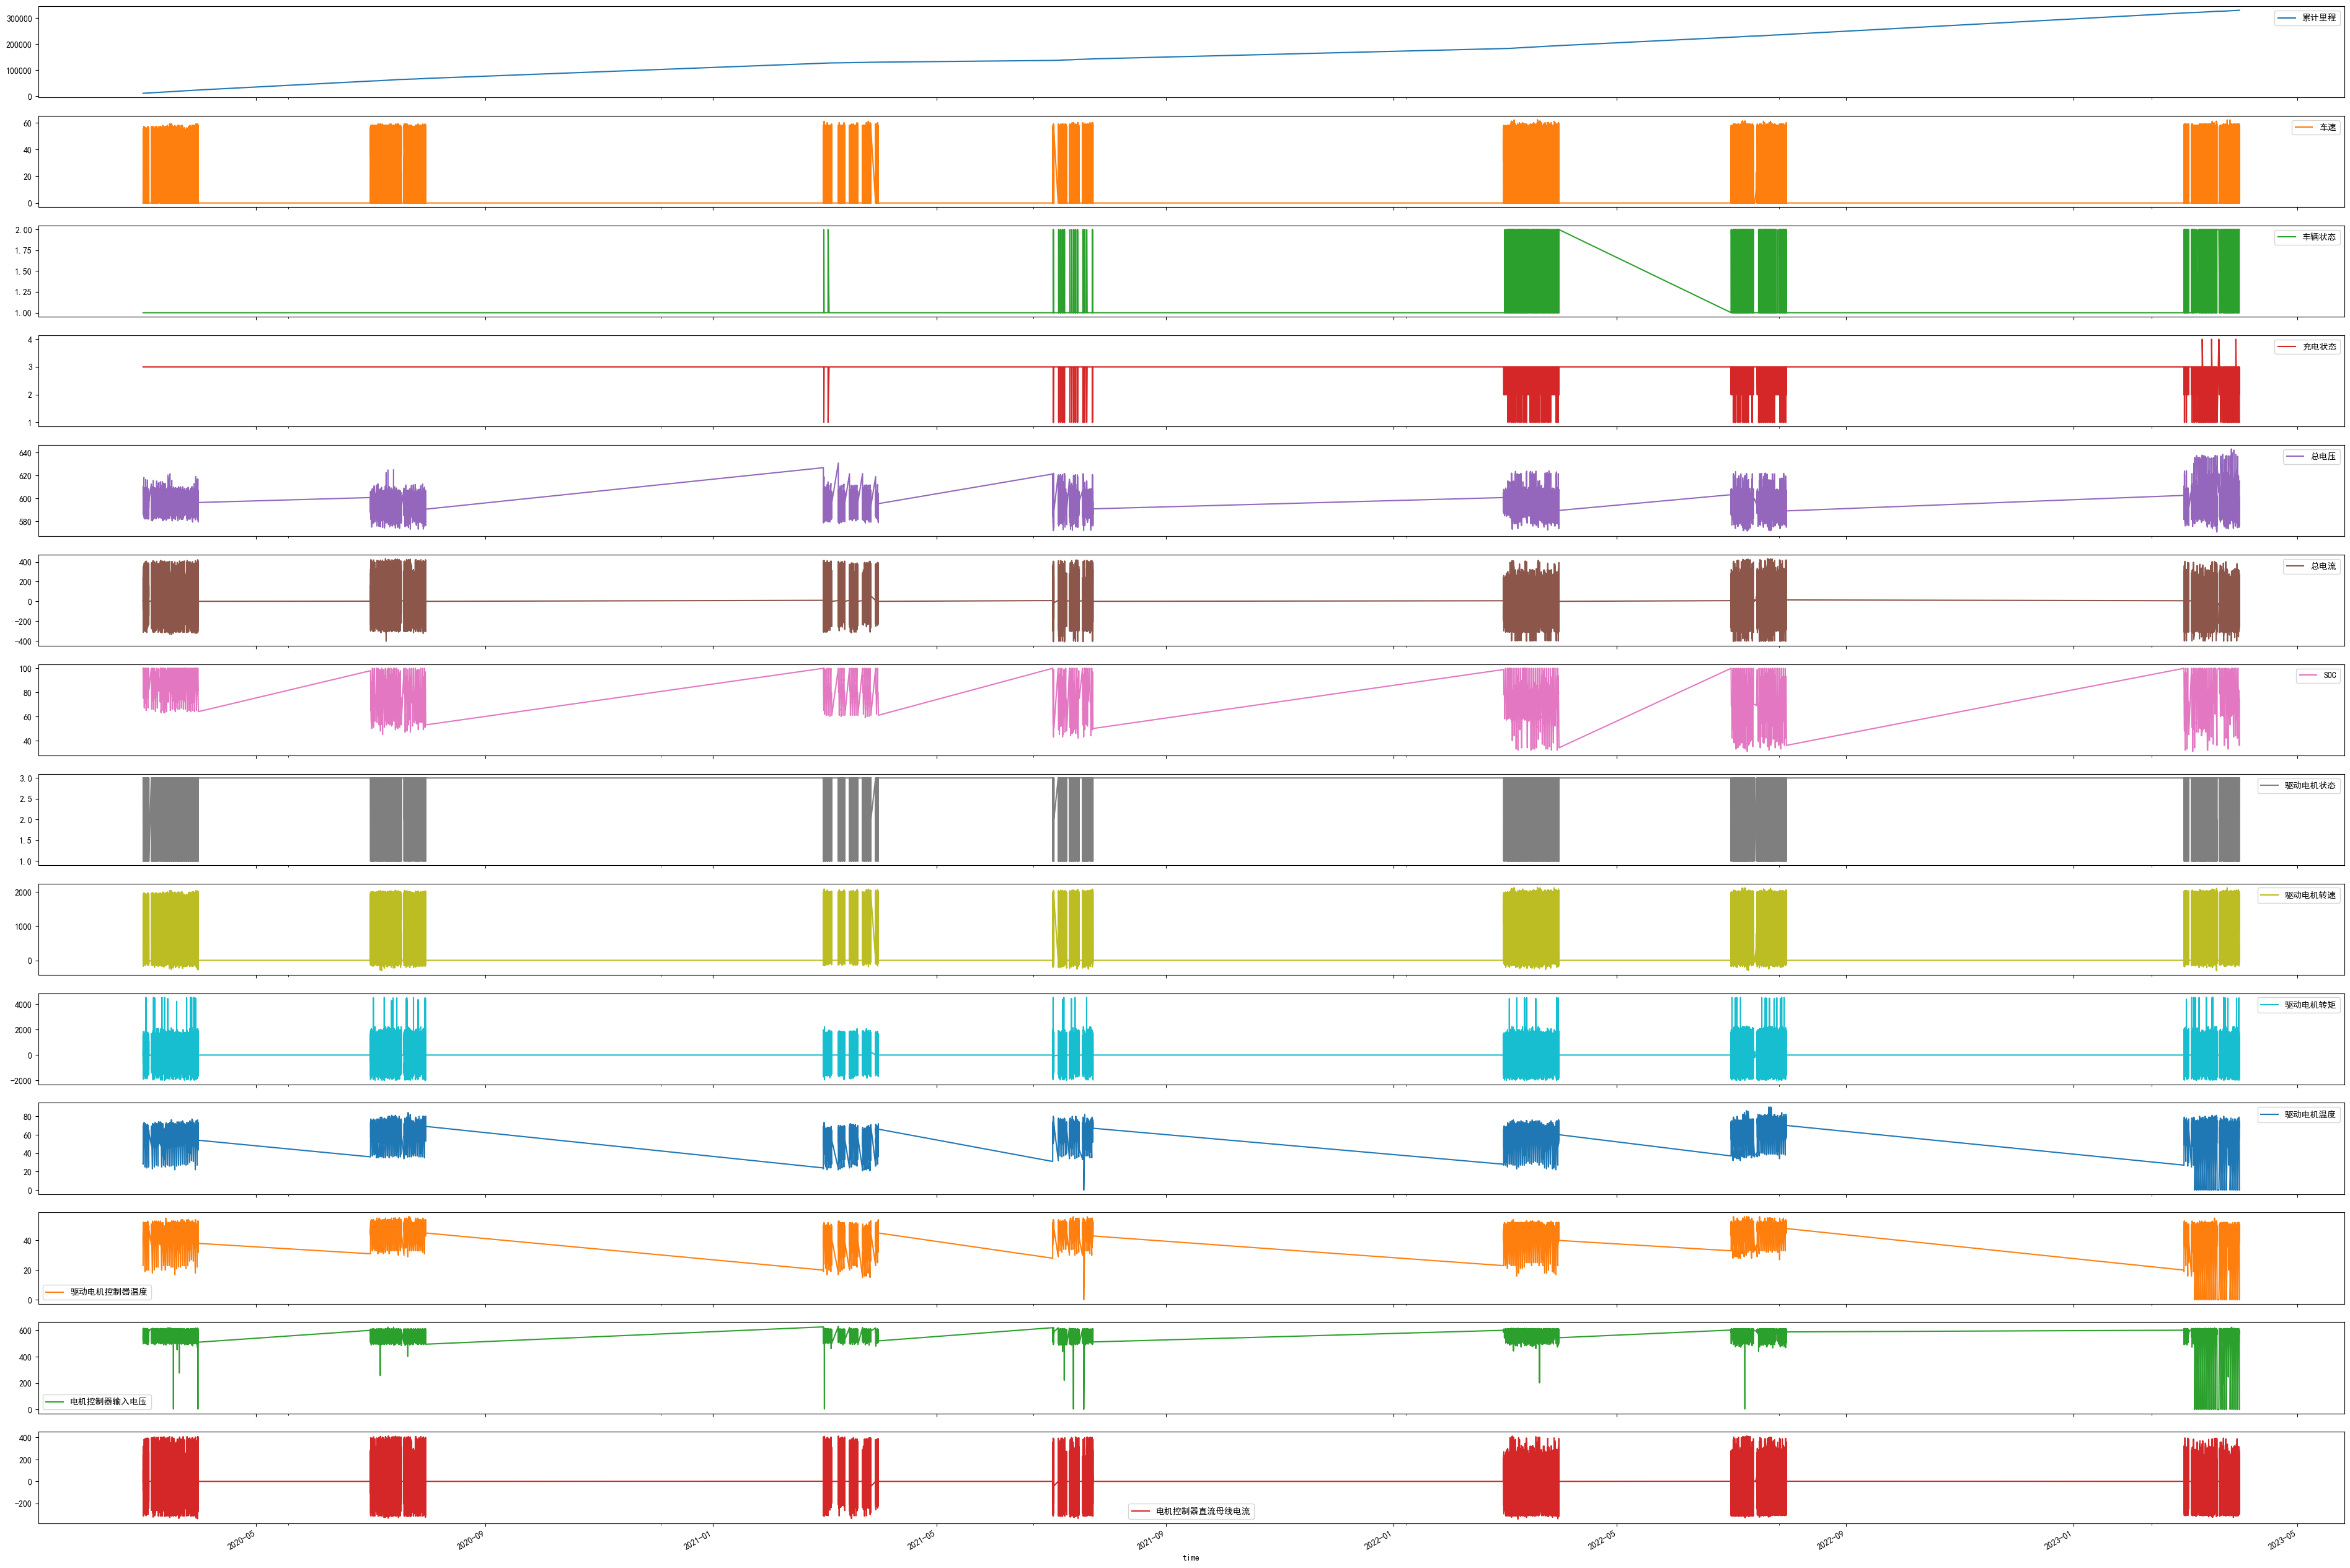

In [16]:
plot_data_withtime(deal_data, len(deal_data))

车辆状态、充电状态绘图发现有问题，在2020-05和2020-09处数据可能不对；待处理

# 4.分字段异常分析

## 4.1 时间分析

In [17]:
# 跨度
Timedelta = deal_data['time'].iloc[-1] - deal_data['time'].iloc[0]
print(Timedelta)

1124 days 17:25:08


In [18]:
# 采样频率（百分比）
deal_data['time_diff'] = deal_data['time'].diff()
print(deal_data['time_diff'].value_counts(normalize=True).apply(lambda x: x*100))

time_diff
0 days 00:00:15    83.521509
0 days 00:00:16    10.945161
0 days 00:00:17     3.508652
0 days 00:00:18     0.310928
0 days 00:00:14     0.292464
                     ...    
0 days 12:39:13     0.000228
0 days 00:11:01     0.000228
0 days 05:23:56     0.000228
0 days 00:26:30     0.000228
0 days 01:44:16     0.000228
Name: proportion, Length: 1496, dtype: float64


In [19]:
print(deal_data['time_diff'].max())

220 days 08:31:54


大部分采样时间间隔为15s，也有采样时间间隔为几百天的，说明数据不连续。

## 4.2 SOC

### 4.2.1 分布图

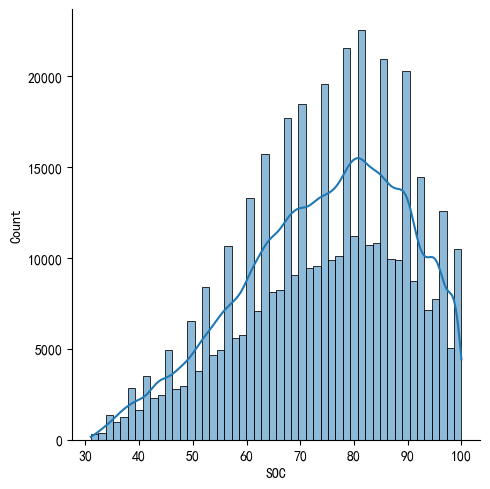

In [20]:
sns.displot(deal_data['SOC'], bins = 50, kde = True)

分布不是很均匀，有比较多的尖峰，待分析

### 4.2.2 散点图

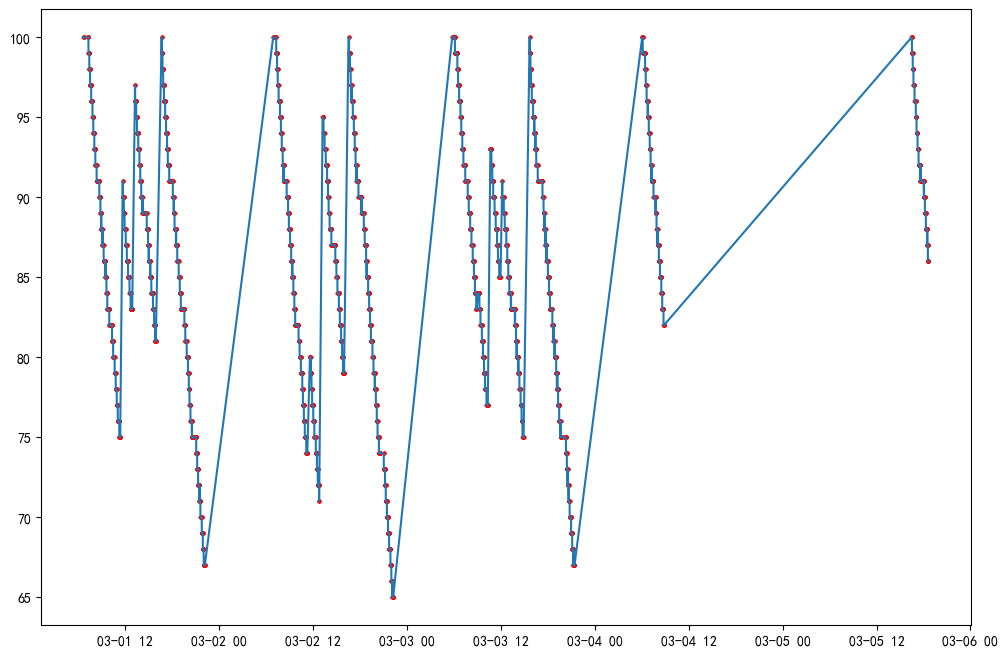

In [21]:
plt.figure(figsize=(12, 8), dpi=100)
test = deal_data[0:10000]
plt.scatter(test['time'],test['SOC'], s=3, color='r')
plt.plot(test['time'], test['SOC'])

部分数据只有放电段

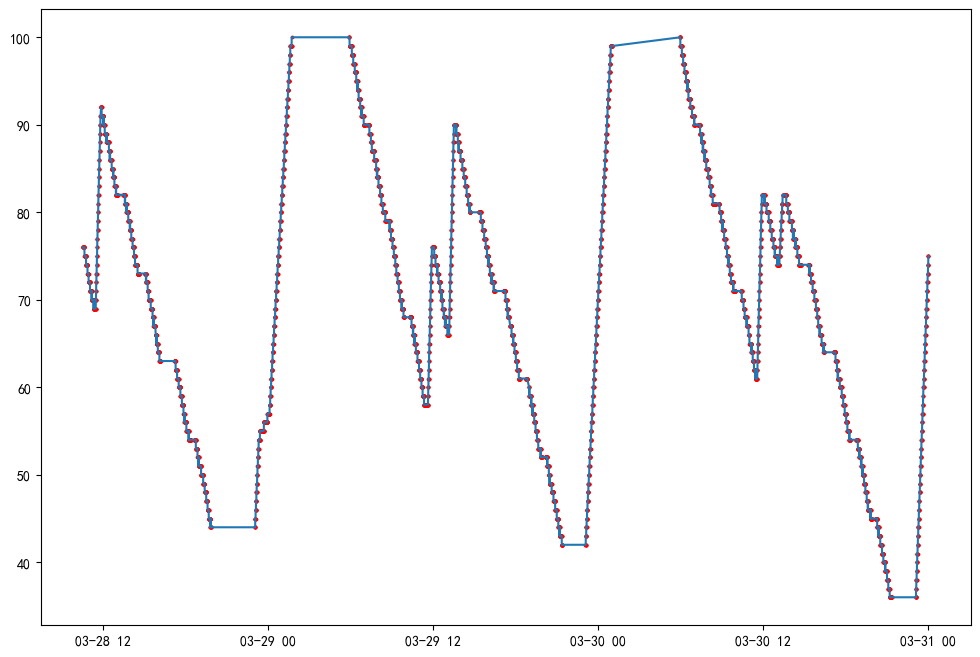

In [22]:
plt.figure(figsize=(12, 8), dpi=100)
test = deal_data[430000:440000]
plt.scatter(test['time'],test['SOC'], s=3, color='r')
plt.plot(test['time'], test['SOC'])

部分数据既有放电也有充电段

### 4.2.3 查看SOC==100

In [23]:
soc_100 = deal_data.query('SOC == 100')
print(len(soc_100))

2264


In [24]:
# 可修复异常，即突变为100的点,最终发现无这样的点
soc_100_list = soc_100.index.to_list()
repair = []
delta = pd.Timedelta(minutes=1)
for i in soc_100_list:
    if i + 1 == len(deal_data):
        pass
    elif i == 0:
        pass
    else:
        t_delta1 = deal_data.time[i] - deal_data.time[i-1]
        t_delta2 = deal_data.time[i+1] - deal_data.time[i]
        if deal_data.SOC[i] == 100 and deal_data.SOC[i+1] <= 98 and deal_data.SOC[i-1] <= 98 and t_delta1 < delta and t_delta2 < delta:
            repair.append(i)
len(repair)


0

## 4.3 车速

### 4.3.1 分布图

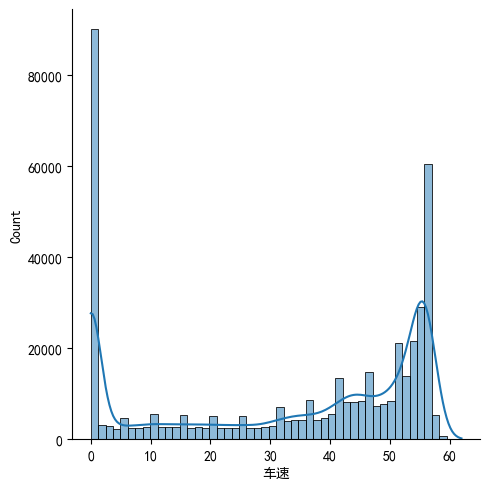

In [25]:
sns.displot(deal_data['车速'], bins =50, kde = True)

车速分布不均匀，除了尖峰之外，在0和在56左右出现的频率较高，待分析。

### 4.3.2 散点图

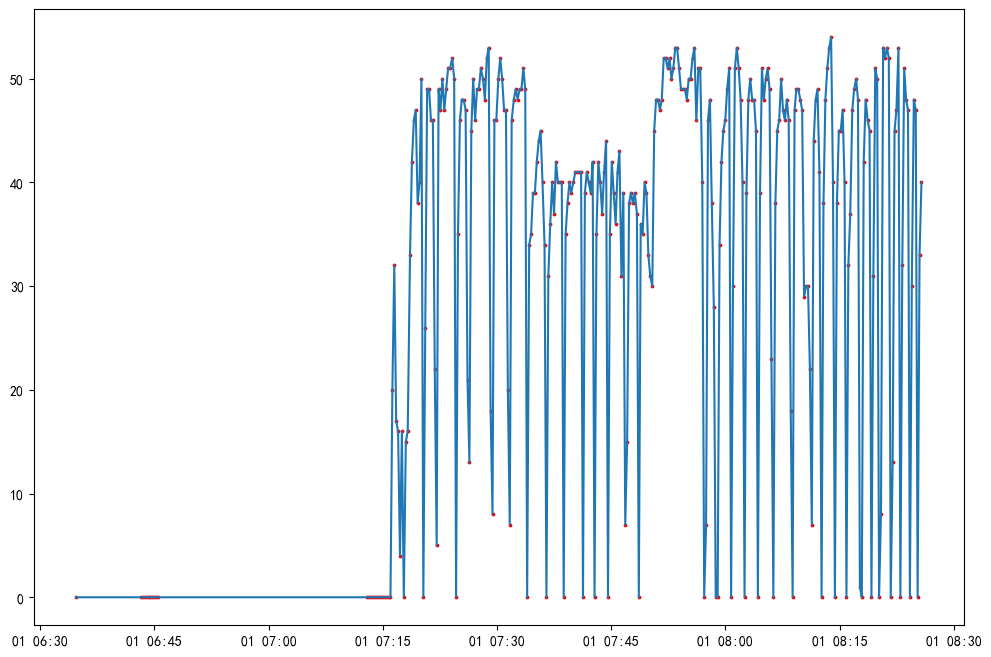

In [26]:
plt.figure(figsize=(12, 8), dpi=100)
test = deal_data[0:300]
plt.scatter(test['time'],test['车速'], s=3, color='r')
plt.plot(test['time'], test['车速'])

为什么车速频繁降为0？

### 4.3.3 车速为0

仅车速为0

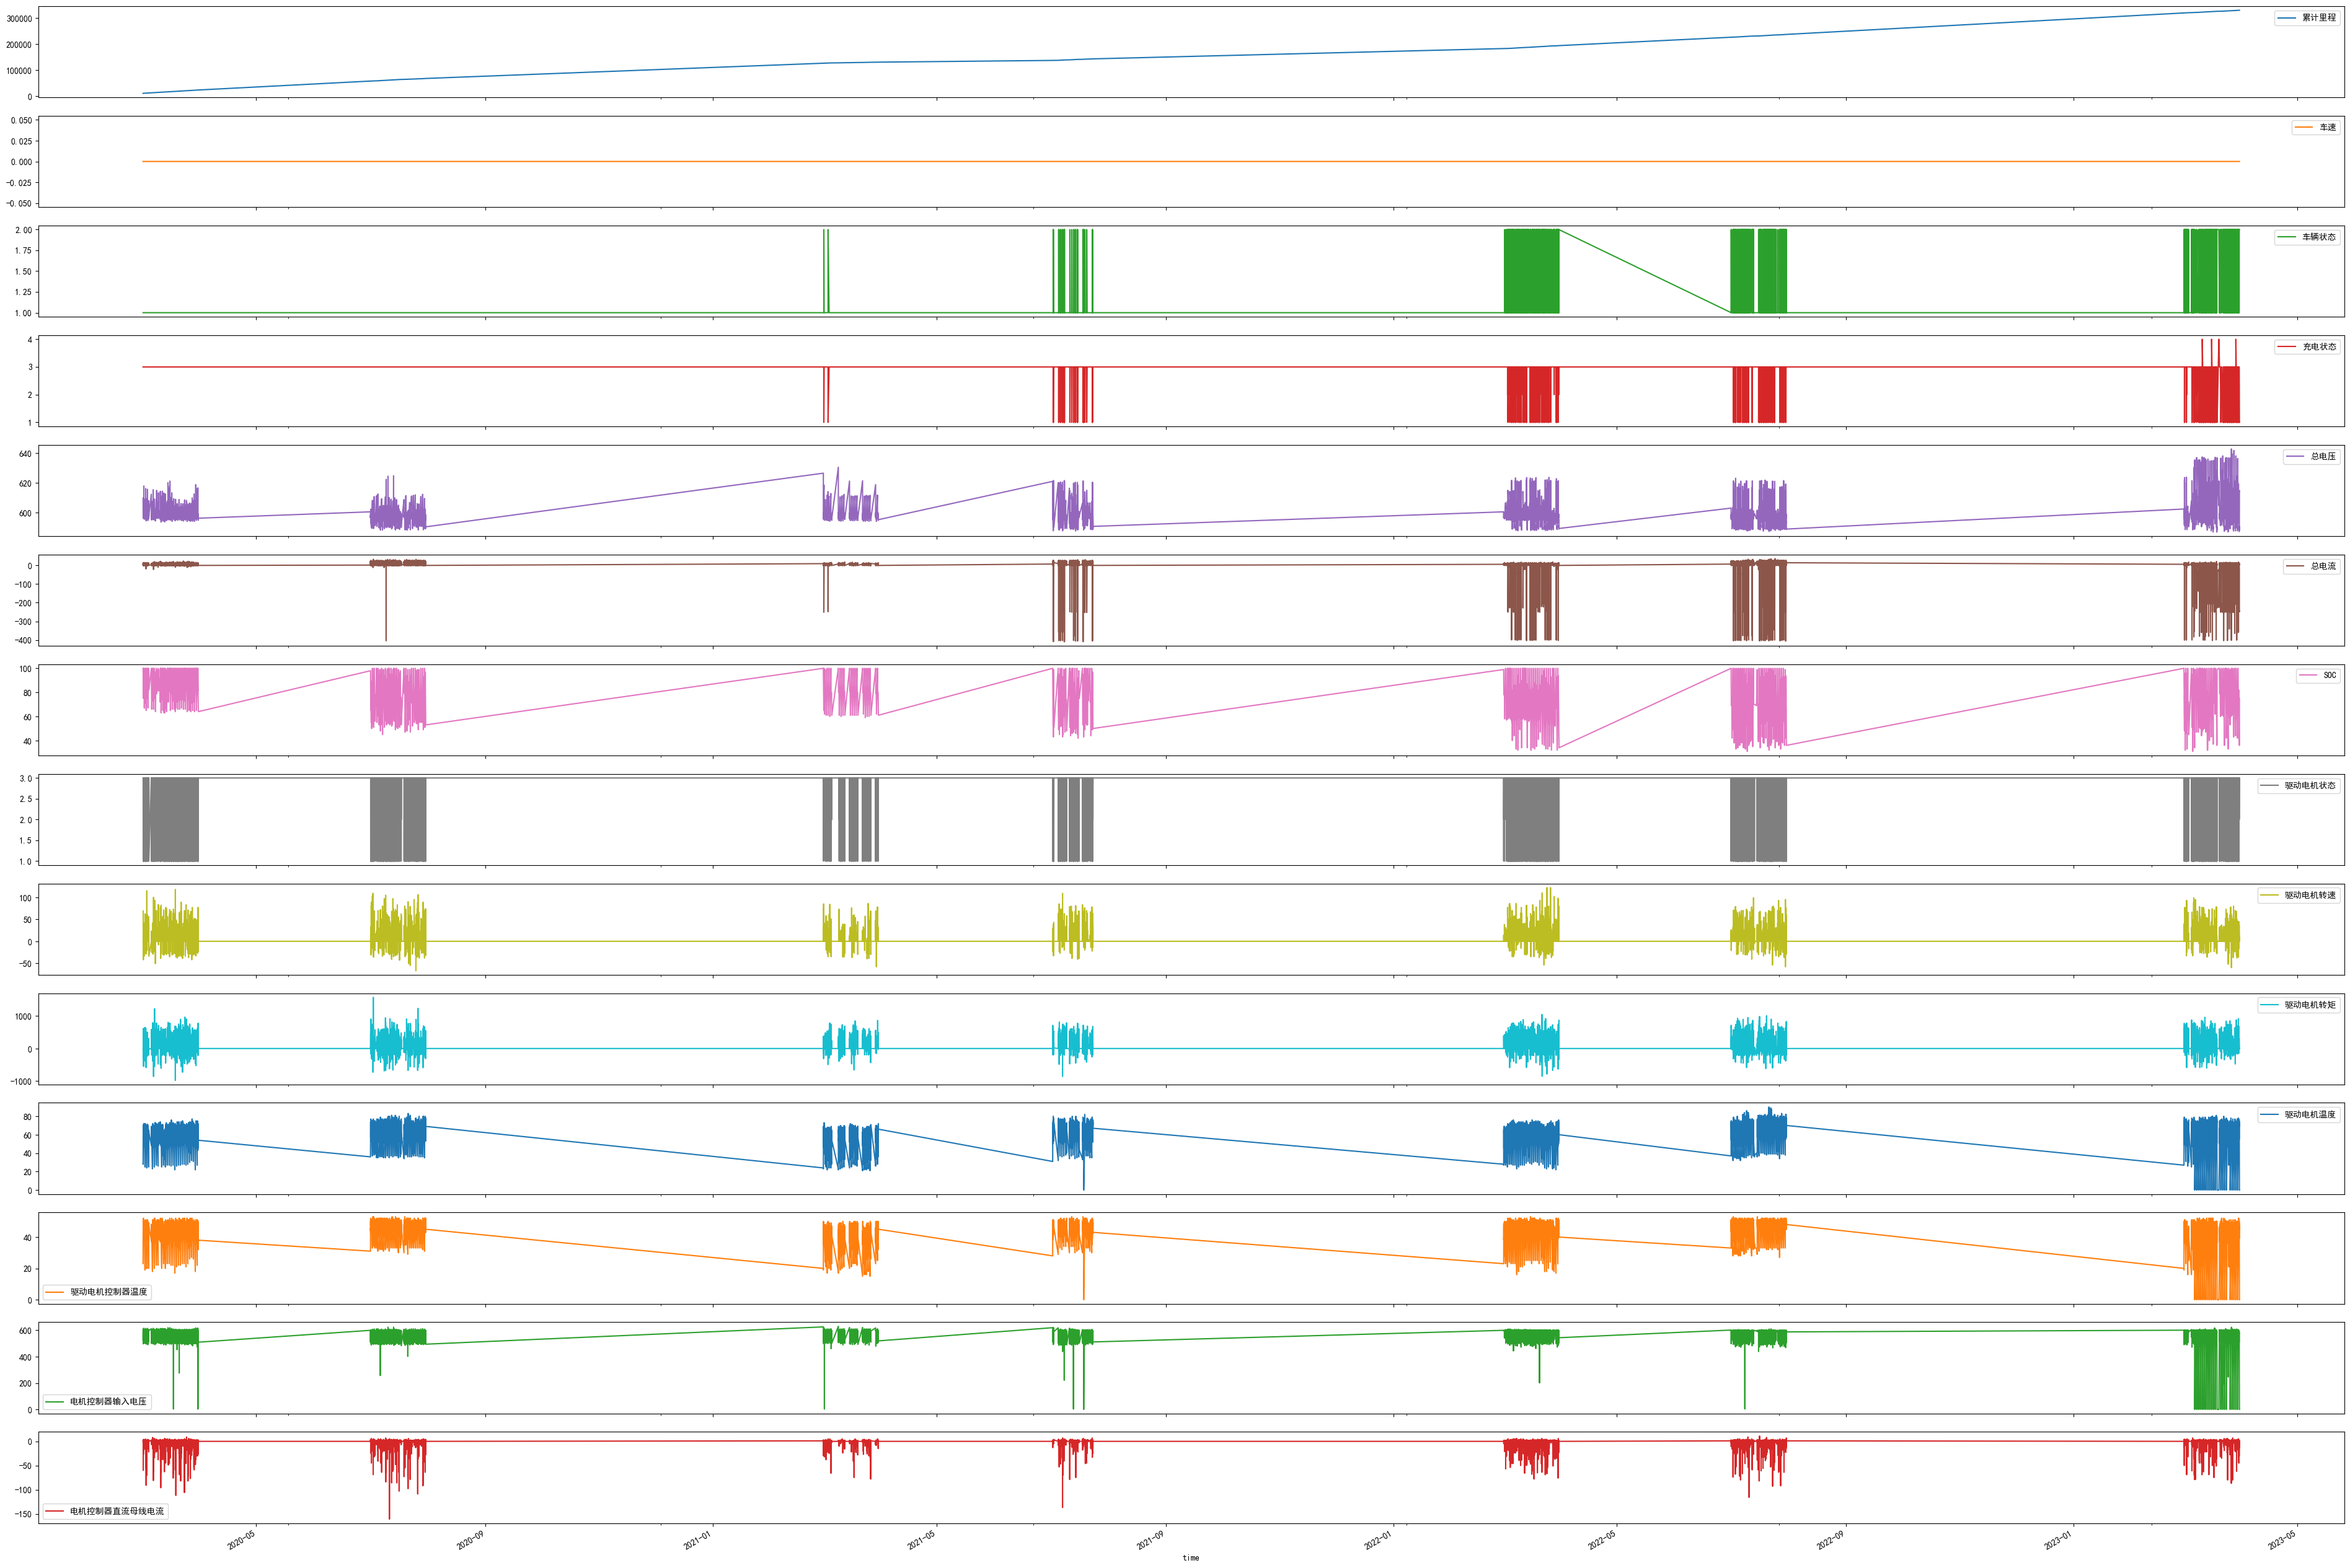

In [27]:
plot_data_withtime(deal_data.query('车速 == 0'),len(deal_data.query('车速 == 0')))

车速为0时充电状态1-4均有可能，车辆状态1-2均可能，且仍然存在部分数据区间车辆状态和充电状态异常现象。

车速、电流均为0

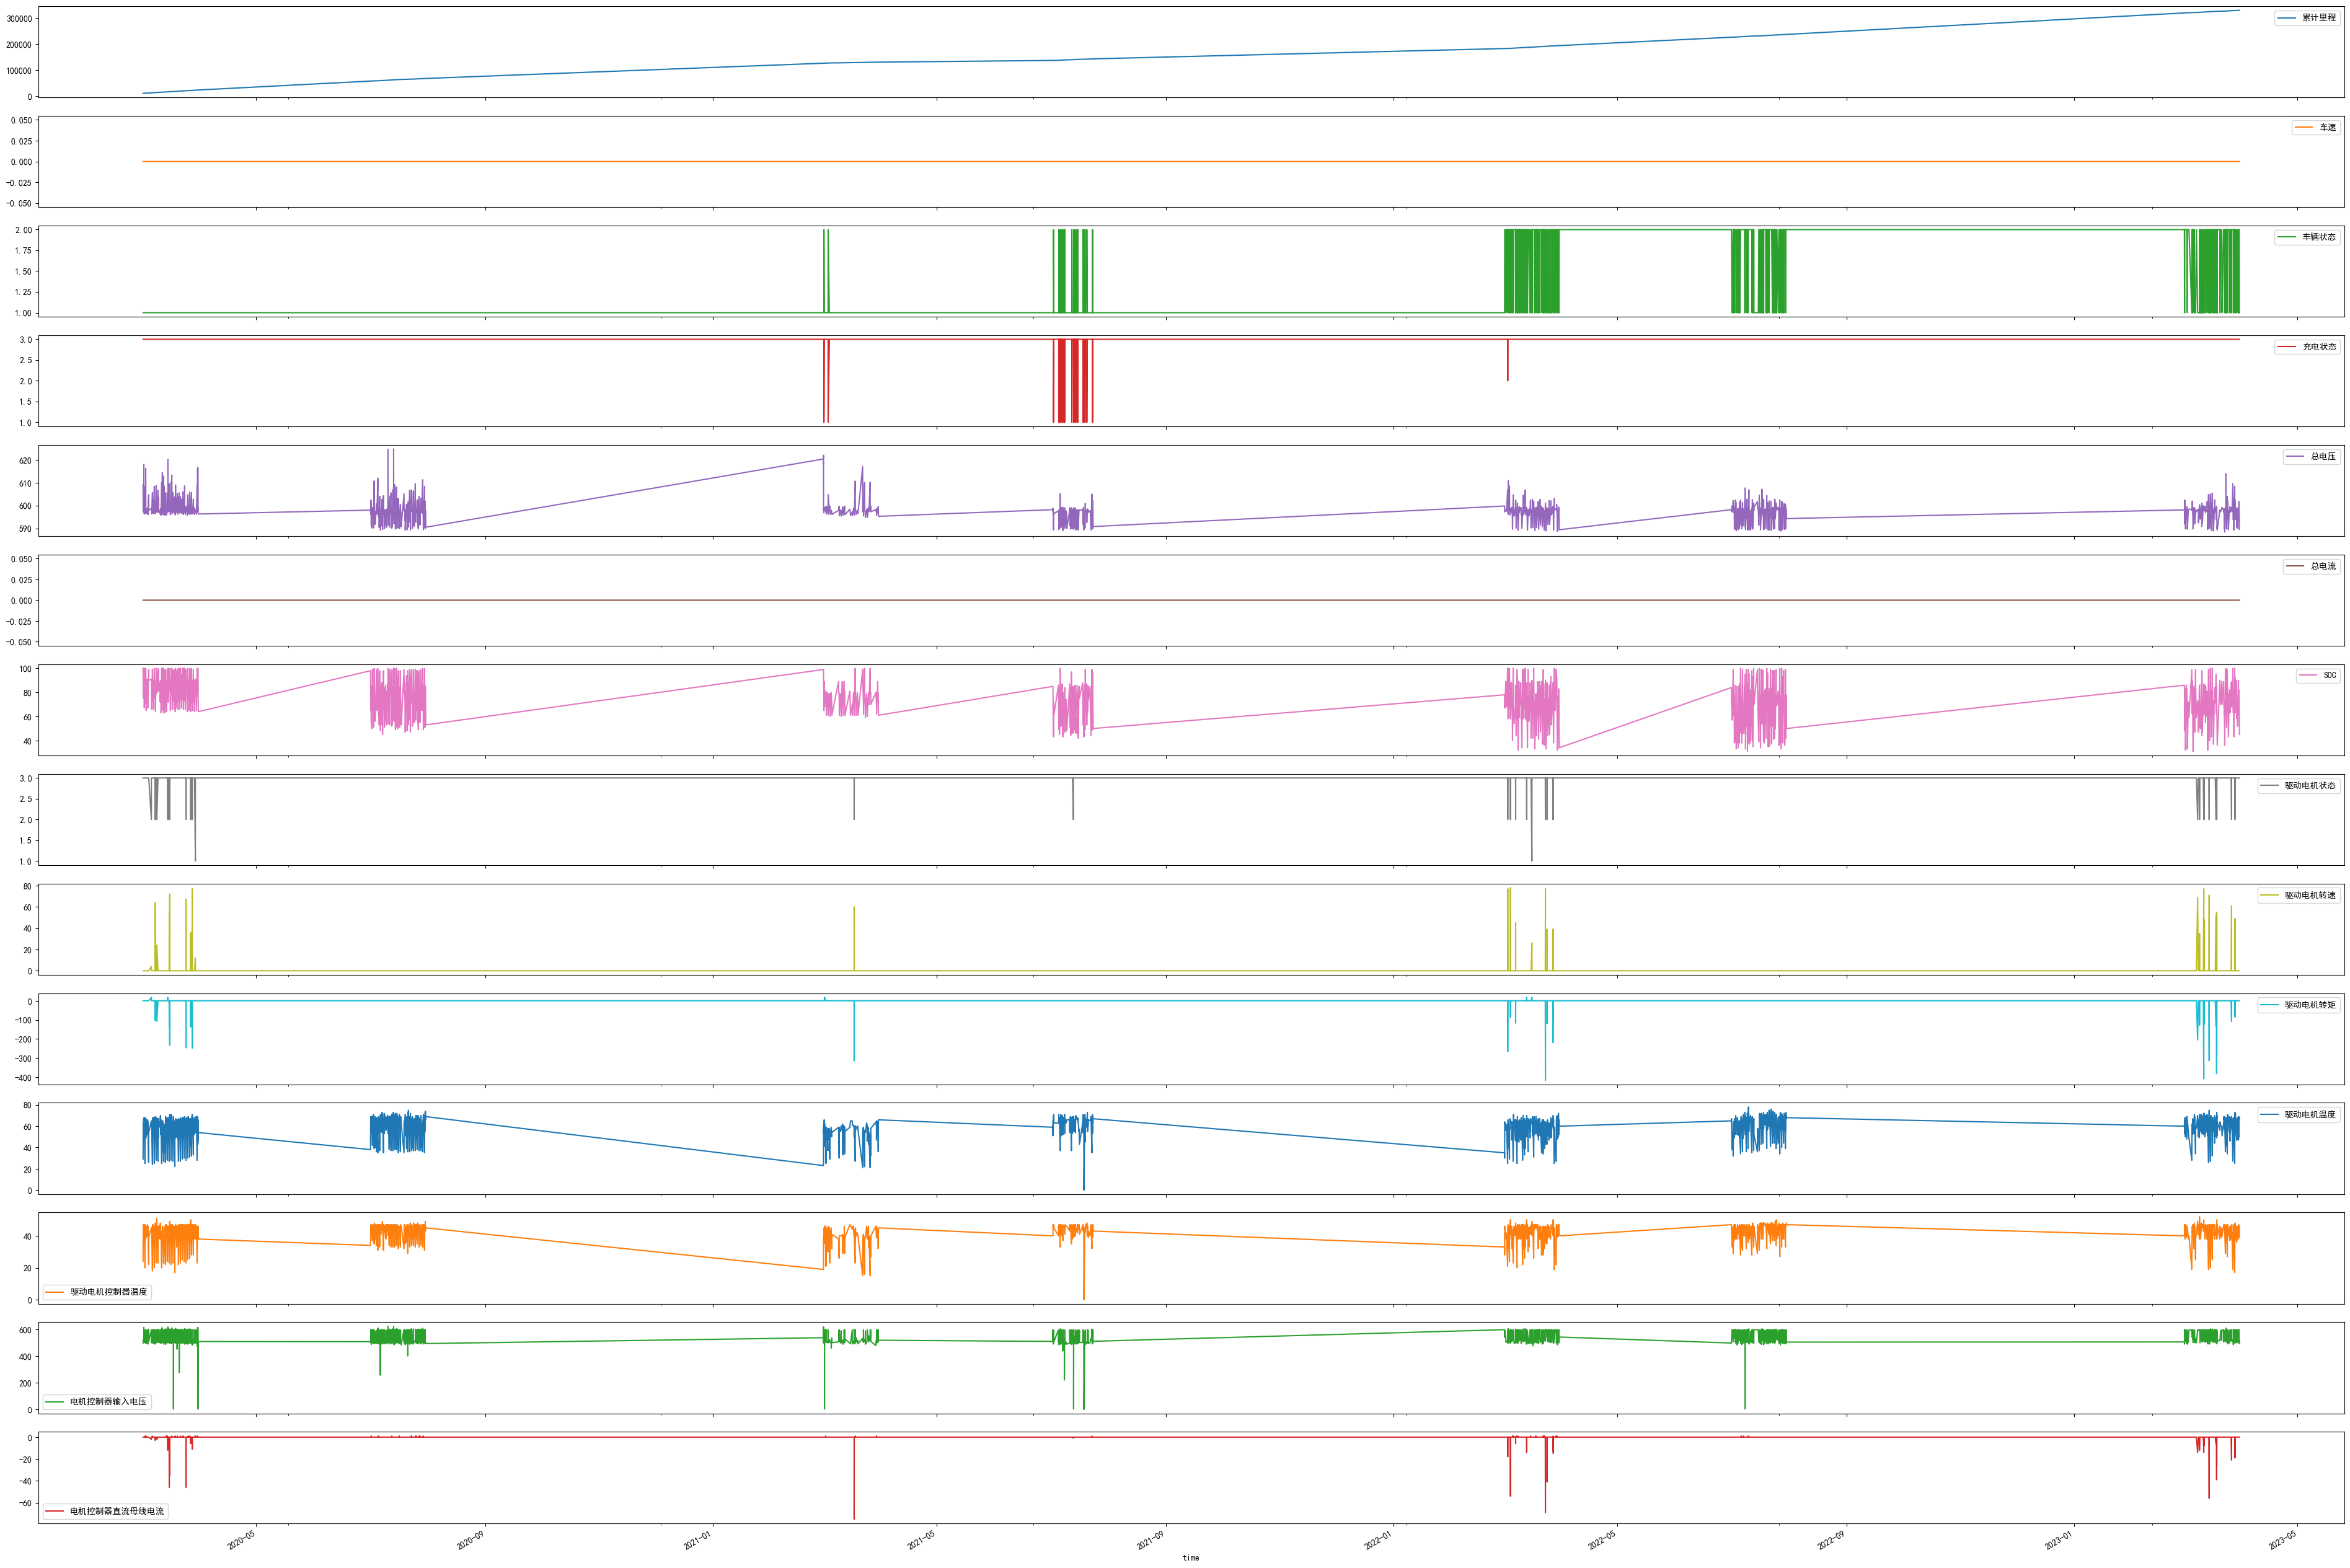

In [28]:
plot_data_withtime(deal_data.query('车速 == 0 & 总电流 ==0'),len(deal_data.query('车速 == 0 & 总电流 ==0')))

车速和总电流均为0时，车辆状态1-2均有可能，充电状态有可能是1停车充电，也可能是3未充电。

## 4.4 里程

### 4.4.1 分布图

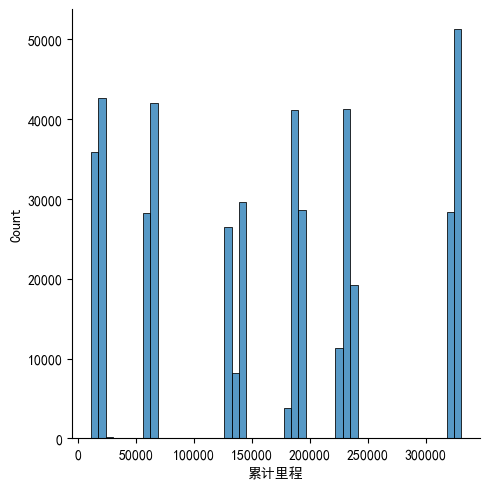

In [29]:
sns.displot(deal_data['累计里程'], bins =50, kde = False)

里程不连续，说明车辆运行数据非连续，给出的数据为多段时间区间内的车辆运行数据。

### 4.4.2 散点图

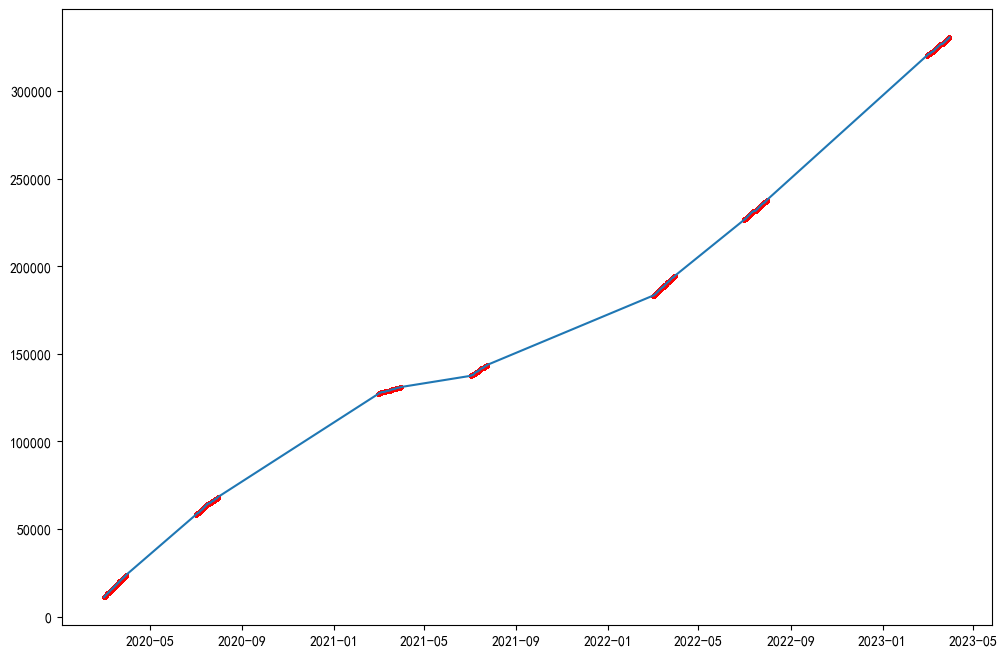

In [30]:
plt.figure(figsize=(12, 8), dpi=100)
test = deal_data[:]
plt.scatter(test['time'],test['累计里程'], s=3, color='r')
plt.plot(test['time'], test['累计里程'])

从上图也可以看出车辆数据为不同时间段。

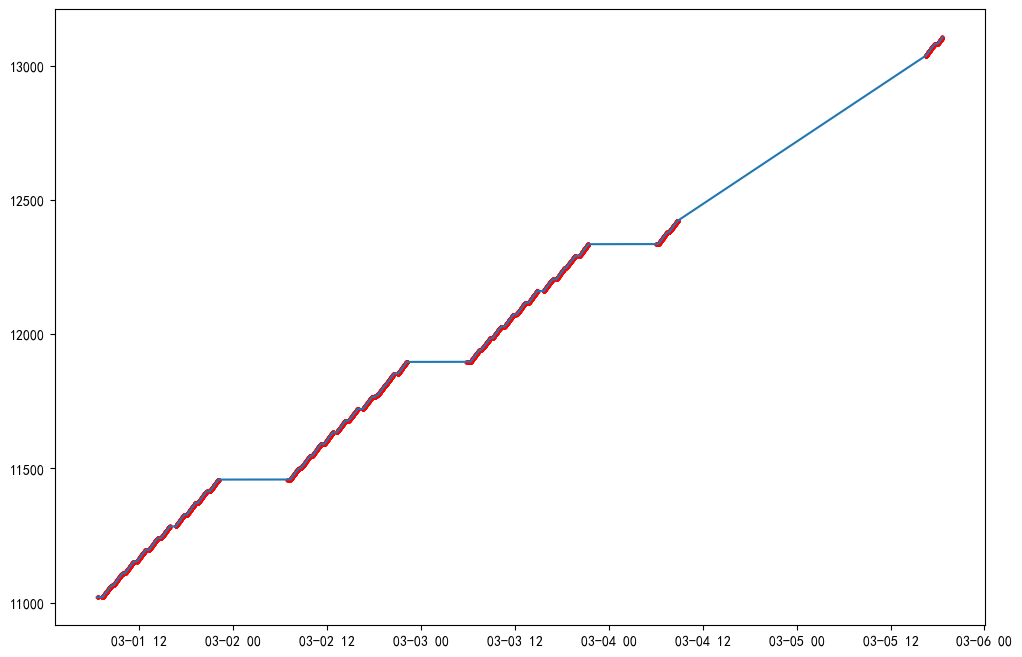

In [31]:
plt.figure(figsize=(12, 8), dpi=100)
test = deal_data[0:10000]
plt.scatter(test['time'],test['累计里程'], s=3, color='r')
plt.plot(test['time'], test['累计里程'])

从上图也可以看出车辆行驶里程数据连续、无异常突变值。

## 4.5 总电压

### 4.5.1 分布图

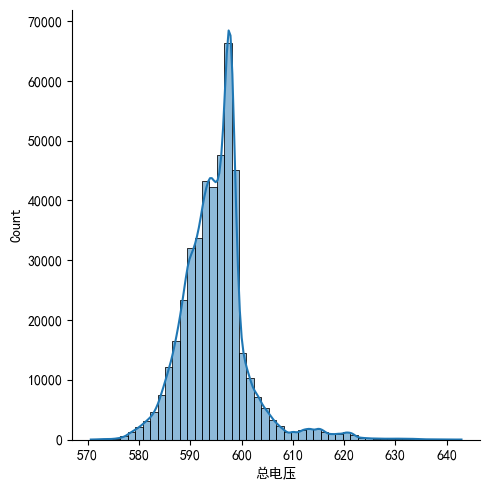

In [32]:
sns.displot(deal_data['总电压'], bins =50, kde = True)

### 4.5.2 散点图

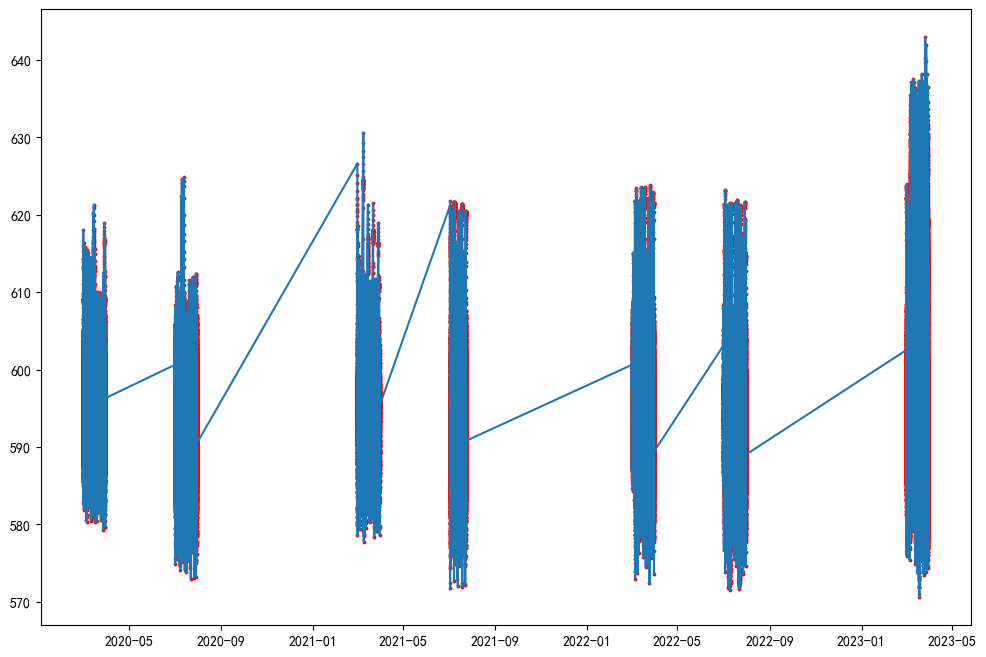

In [33]:
plt.figure(figsize=(12, 8), dpi=100)
test = deal_data[:]
plt.scatter(test['time'],test['总电压'], s=3, color='r')
plt.plot(test['time'], test['总电压'])

## 4.6 总电流

### 4.6.1 分布图

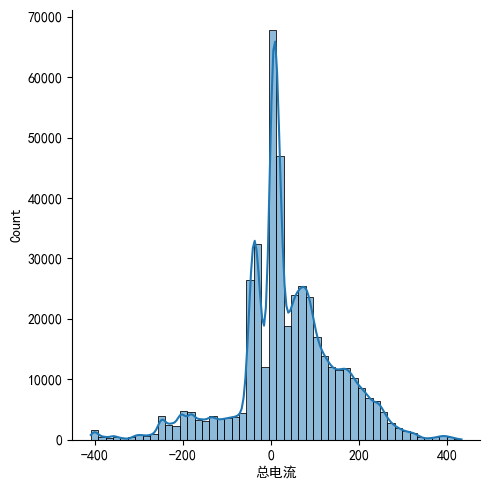

In [34]:
sns.displot(deal_data['总电流'], bins =50, kde = True)

### 4.6.2 散点图

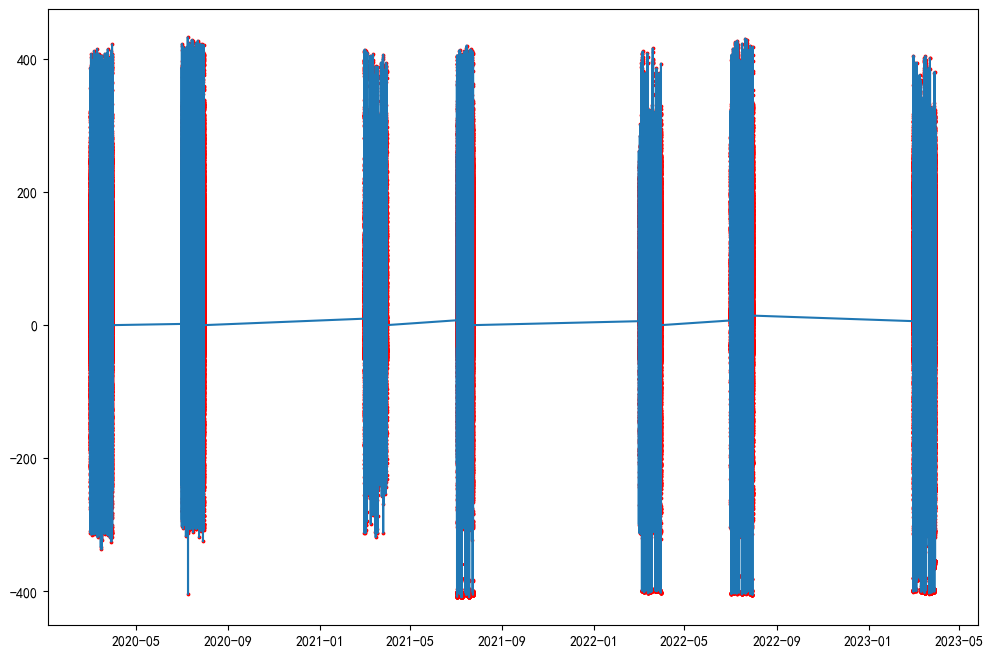

In [35]:
plt.figure(figsize=(12, 8), dpi=100)
test = deal_data[:]
plt.scatter(test['time'],test['总电流'], s=3, color='r')
plt.plot(test['time'], test['总电流'])

2021-5月之后，总电流稍降。

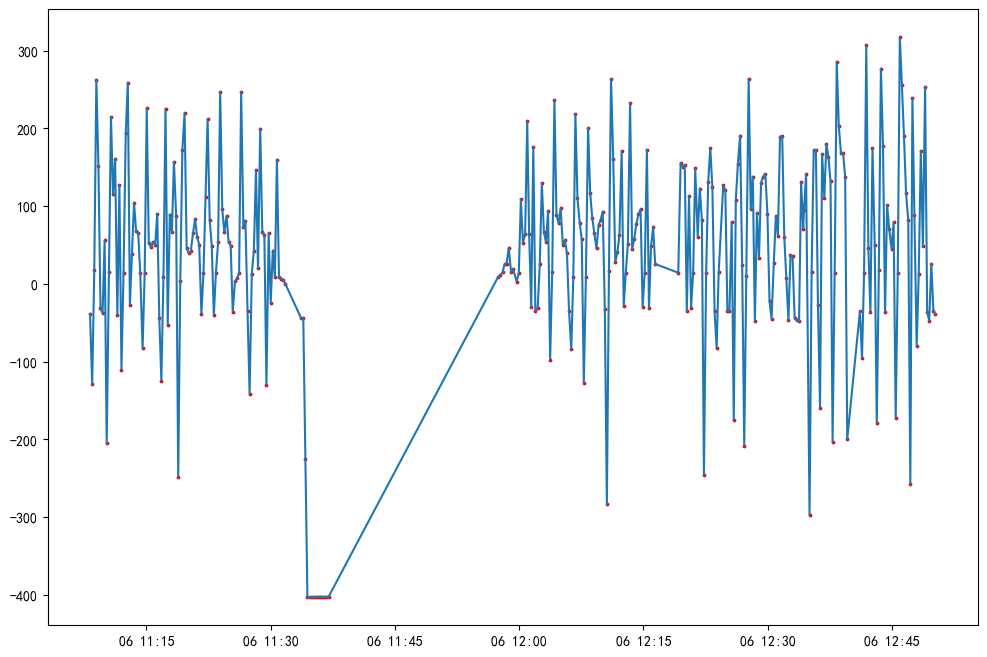

In [36]:
plt.figure(figsize=(12, 8), dpi=100)
test = deal_data[300500:300800]
plt.scatter(test['time'],test['总电流'], s=3, color='r')
plt.plot(test['time'], test['总电流'])

## 4.7 绝缘电阻

### 4.7.1 分布图

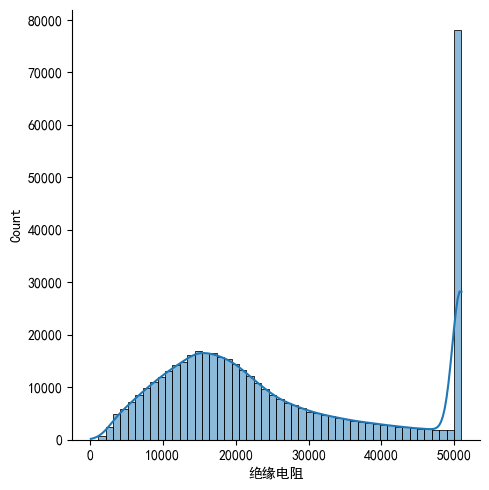

In [37]:
sns.displot(deal_data['绝缘电阻'], bins =50, kde = True)

绝缘电阻50000KΩ附近有尖峰。

### 4.7.2 散点图

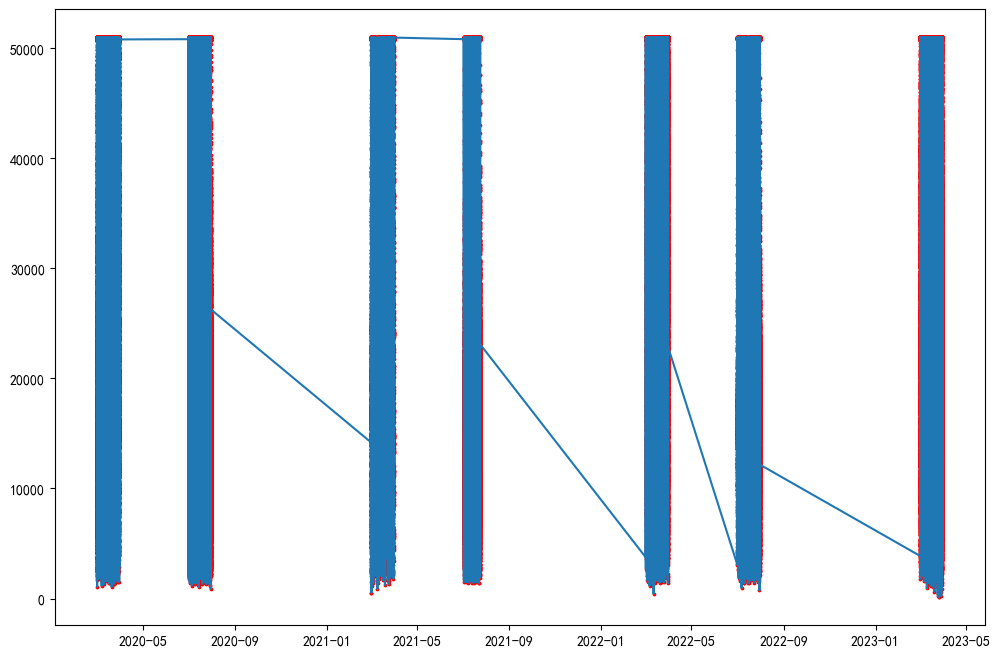

In [38]:
plt.figure(figsize=(12, 8), dpi=100)
test = deal_data[:]
plt.scatter(test['time'],test['绝缘电阻'], s=3, color='r')
plt.plot(test['time'], test['绝缘电阻'])

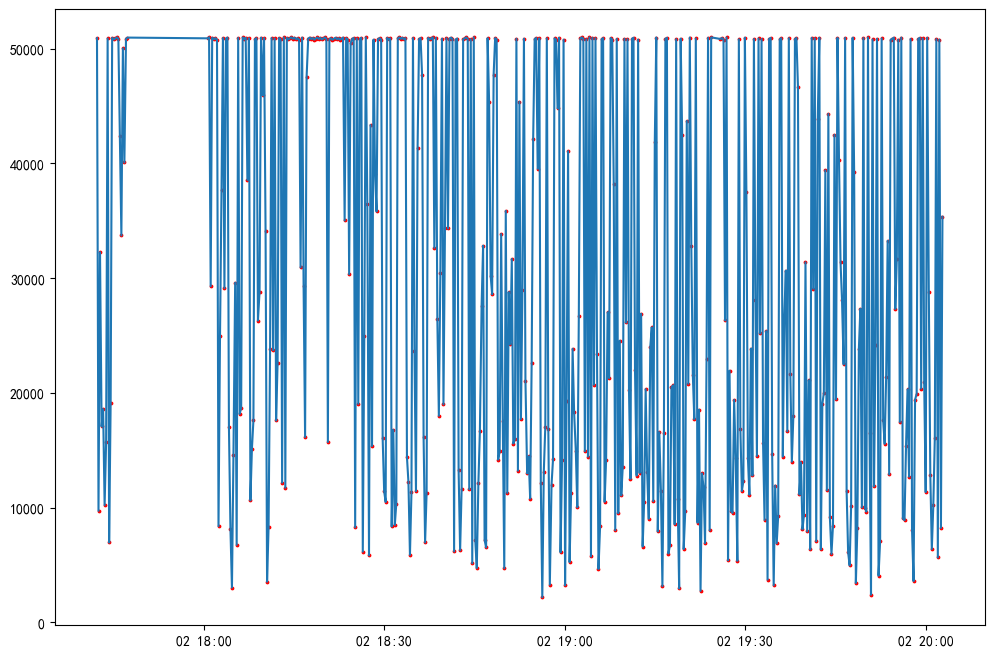

In [39]:
plt.figure(figsize=(12, 8), dpi=100)
test = deal_data[5000:5500]
plt.scatter(test['time'],test['绝缘电阻'], s=3, color='r')
plt.plot(test['time'], test['绝缘电阻'])

绝缘电阻最大值50000KΩ处分布近似一条直线。

## 4.8 经纬度

### 4.8.1 分布情况

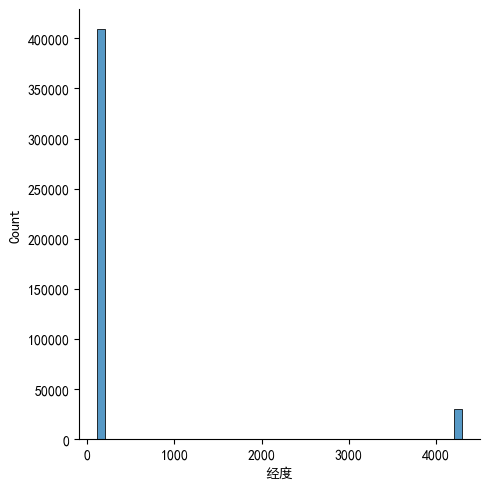

In [40]:
sns.displot(deal_data['经度'], bins =50, kde = False)

In [41]:
deal_data['经度'].value_counts()

经度
4294.967294    20414
4294.967295     9377
118.132723       491
118.133260       463
118.132940       235
               ...  
118.072185         1
118.070283         1
118.072348         1
118.074513         1
118.107825         1
Name: count, Length: 46321, dtype: int64

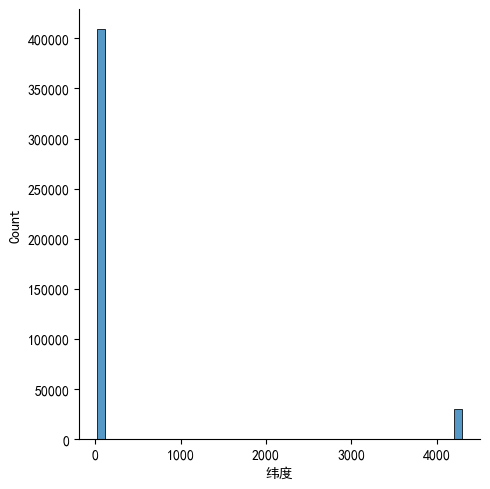

In [42]:
sns.displot(deal_data['纬度'], bins =50, kde = False)

In [43]:
deal_data['纬度'].value_counts()

纬度
4294.967294    20414
4294.967295     9377
24.722358        470
24.721121        460
24.722875        232
               ...  
24.636361          1
24.628740          1
24.628225          1
24.625491          1
24.719785          1
Name: count, Length: 120893, dtype: int64

### 4.8.2 错误分析

In [44]:
deal_data.query('纬度 > 90')['定位状态'].value_counts()

定位状态
1    29791
Name: count, dtype: int64

经纬度为异常时定位状态为1：无效定位

### 4.8.3 经纬度二维图

In [45]:
map_data = gpd.read_file('./geo/厦门市.json')

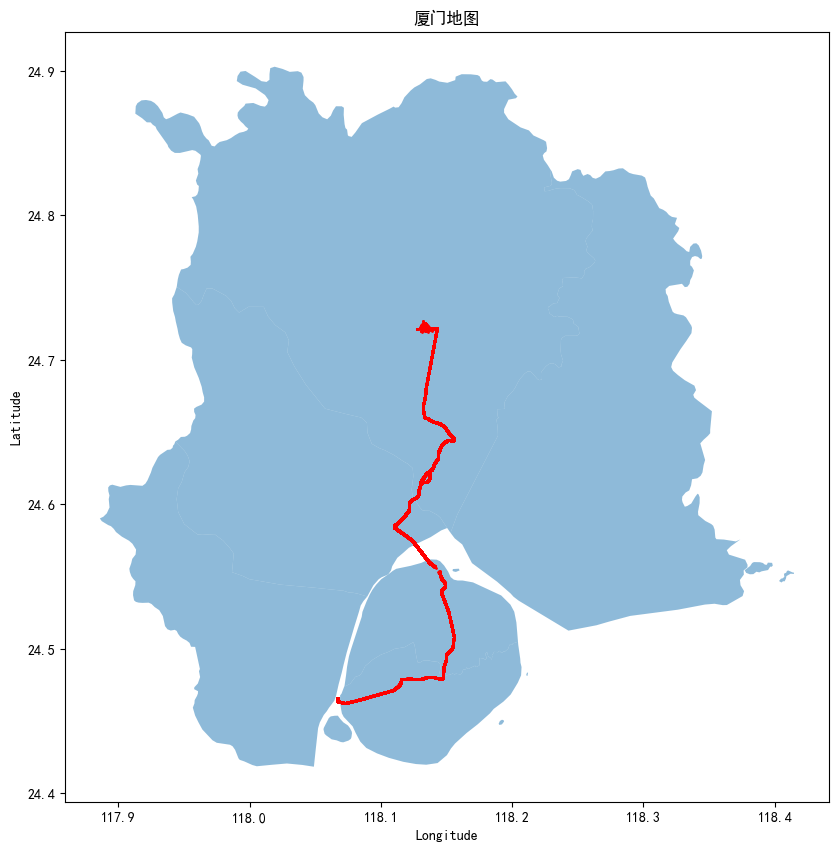

In [46]:
fig, ax = plt.subplots(figsize=(10, 10))
map_data.plot(ax=ax, alpha=0.5)  # 绘制地图边界
ax.scatter(deal_data.query('定位状态 == 0')['经度'], deal_data.query('定位状态 == 0')['纬度'], 
           color='red', s=1)  # 绘制坐标点
plt.title('厦门地图')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

## 4.9 单体电压

### 4.9.1最高值

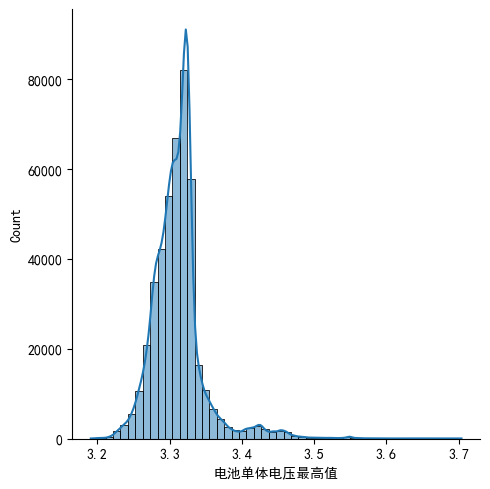

In [47]:
sns.displot(deal_data['电池单体电压最高值'], bins =50, kde = True)

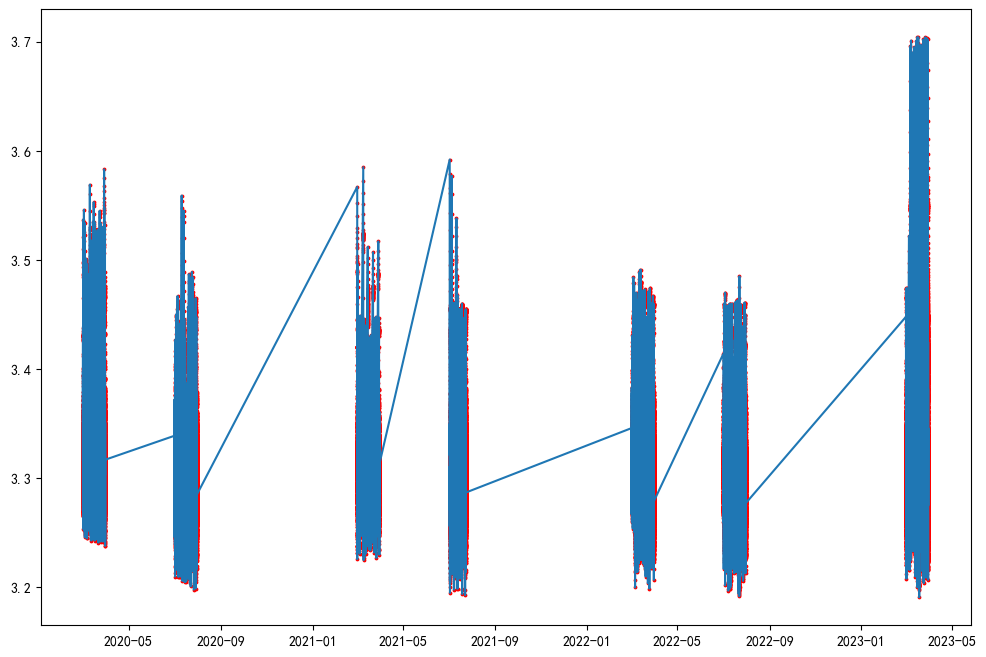

In [48]:
plt.figure(figsize=(12, 8), dpi=100)
test = deal_data[:]
plt.scatter(test['time'],test['电池单体电压最高值'], s=3, color='r')
plt.plot(test['time'], test['电池单体电压最高值'])

2023-5月段运行数据中单体电压最高值上升到3.7左右

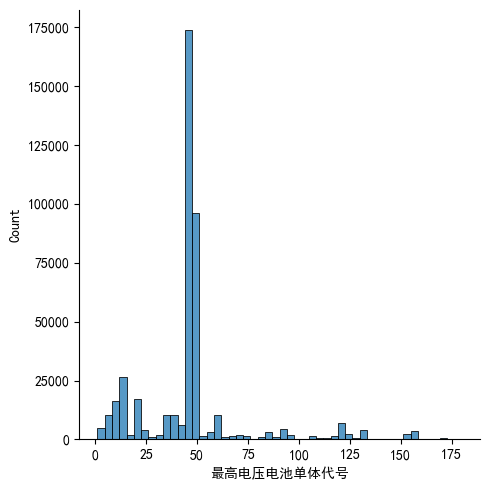

In [49]:
sns.displot(deal_data['最高电压电池单体代号'], bins=50, kde=False)

可以看出单体电池最高电压分布近似正态，对应电池代号有一定聚集性

### 4.9.2 最低值

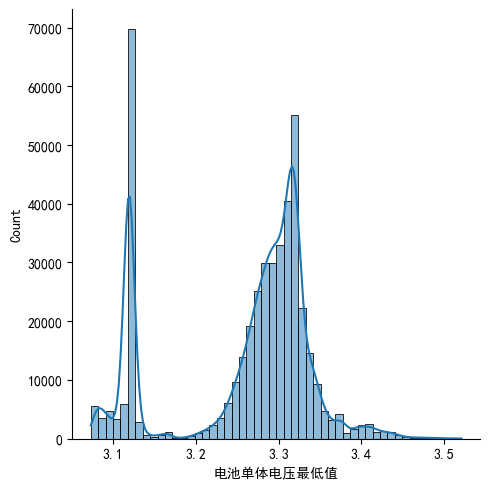

In [50]:
sns.displot(deal_data['电池单体电压最低值'], bins = 50, kde=True)

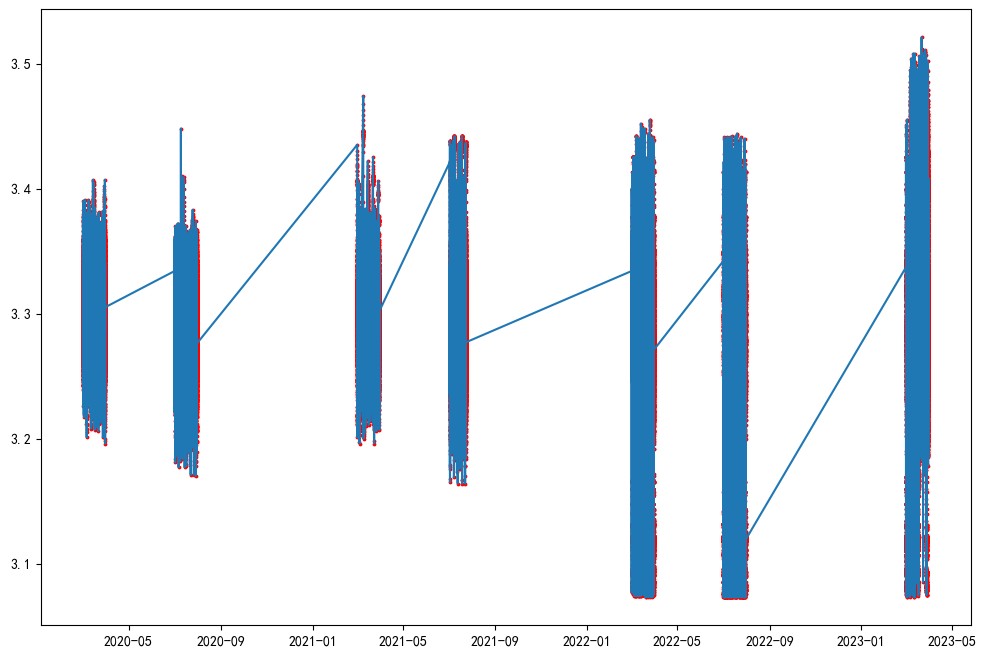

In [51]:
plt.figure(figsize=(12, 8), dpi=100)
test = deal_data[:]
plt.scatter(test['time'],test['电池单体电压最低值'], s=3, color='r')
plt.plot(test['time'], test['电池单体电压最低值'])

可以看出单体电池最低电压在22年之后有所下降。

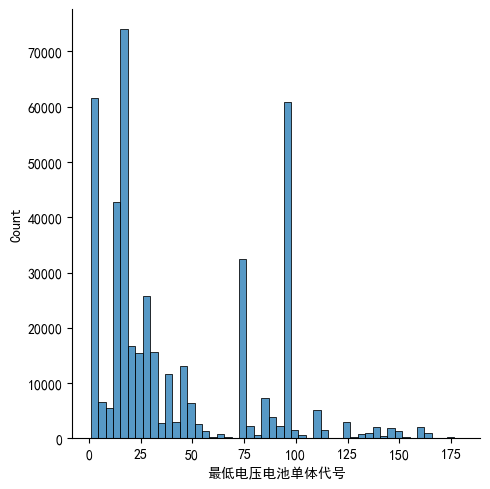

In [52]:
sns.displot(deal_data['最低电压电池单体代号'], bins=50, kde=False)

最低电压电池单体代号有一定聚集性

## 4.10 温度值

### 4.10.1最高温度值

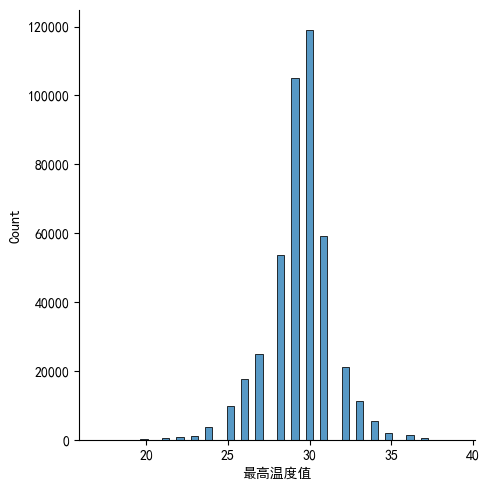

In [53]:
sns.displot(deal_data['最高温度值'], bins = 50)

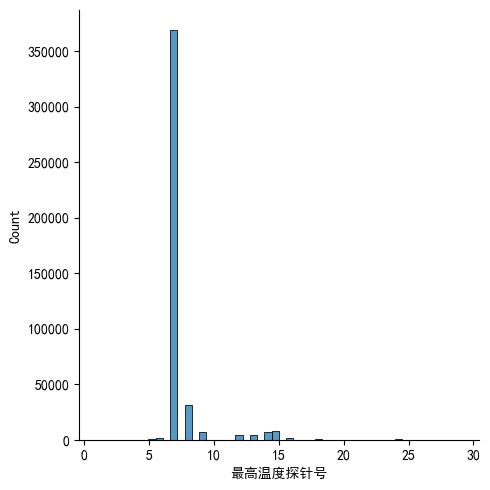

In [54]:
sns.displot(deal_data['最高温度探针号'], bins=50, kde=False)

### 4.10.2 最低温度值

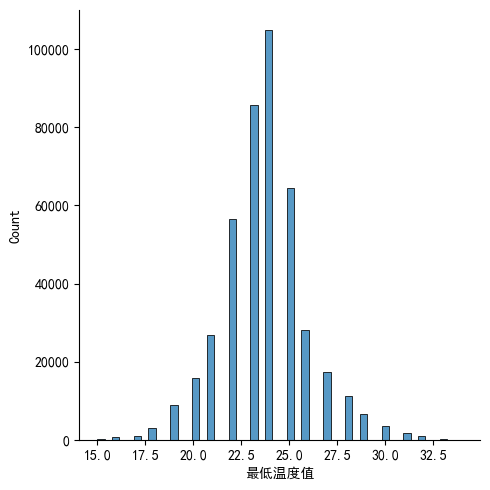

In [55]:
sns.displot(deal_data['最低温度值'], bins=50)

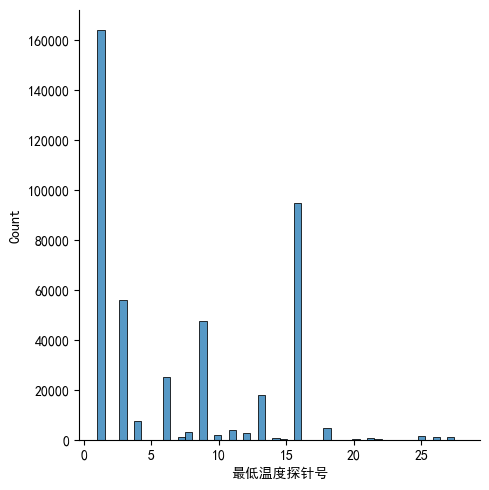

In [56]:
sns.displot(deal_data['最低温度探针号'], bins=50, kde=False)

# 5.状态分析

## 5.1行驶状态

In [57]:
deal_data['车辆状态'].value_counts()  # 1为启动，2为熄火

车辆状态
1    422924
2     15764
Name: count, dtype: int64

In [58]:
# 查看车辆熄火状态下车速大于0的数据
print(len(deal_data.query('车辆状态 == 2 and 车速>0')))

0


## 5.2充电状态

In [59]:
deal_data['充电状态'].value_counts()  # 1为停车充电，2为行驶充电，3为未充电状态，4为充电完成

充电状态
3    372308
2     51112
1     15261
4         7
Name: count, dtype: int64

In [60]:
# 查看停车充电状态下车速大于0的数据
print(len(deal_data.query('充电状态 == 1 and 车速>0')))

0


In [61]:
# 查看还在充电状态下SOC为100的数据
print(len(deal_data.query('充电状态 < 3 and SOC == 100')))

0


In [ ]:
# 查看充电状态为1或2时SOC数据
test = deal_data.query("充电状态 < 3")
plt.figure(figsize=(12, 8), dpi=100)
plt.scatter(test[0:1000]['time'],test[0:1000]['SOC'], s=3, color='r')
plt.plot(test[0:1000]['time'], test[0:1000]['SOC'])

In [ ]:
# 查看停车充电
test1 = deal_data.query("充电状态 == 1")
fig, ax = plt.subplots(figsize=(10, 10))
map_data.plot(ax=ax, alpha=0.5)  # 绘制地图边界
ax.scatter(test1.query('定位状态 == 0')['经度'], test1.query('定位状态 == 0')['纬度'], 
           color='red', s=1)  # 绘制坐标点
plt.title('厦门地图')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# 6.驱动电机及控制器相关分析

## 6.1驱动电机状态

In [62]:
deal_data['驱动电机状态'].value_counts()  # 1为耗电，2为发电，3为关闭状态。

驱动电机状态
1    241583
2    114689
3     82416
Name: count, dtype: int64

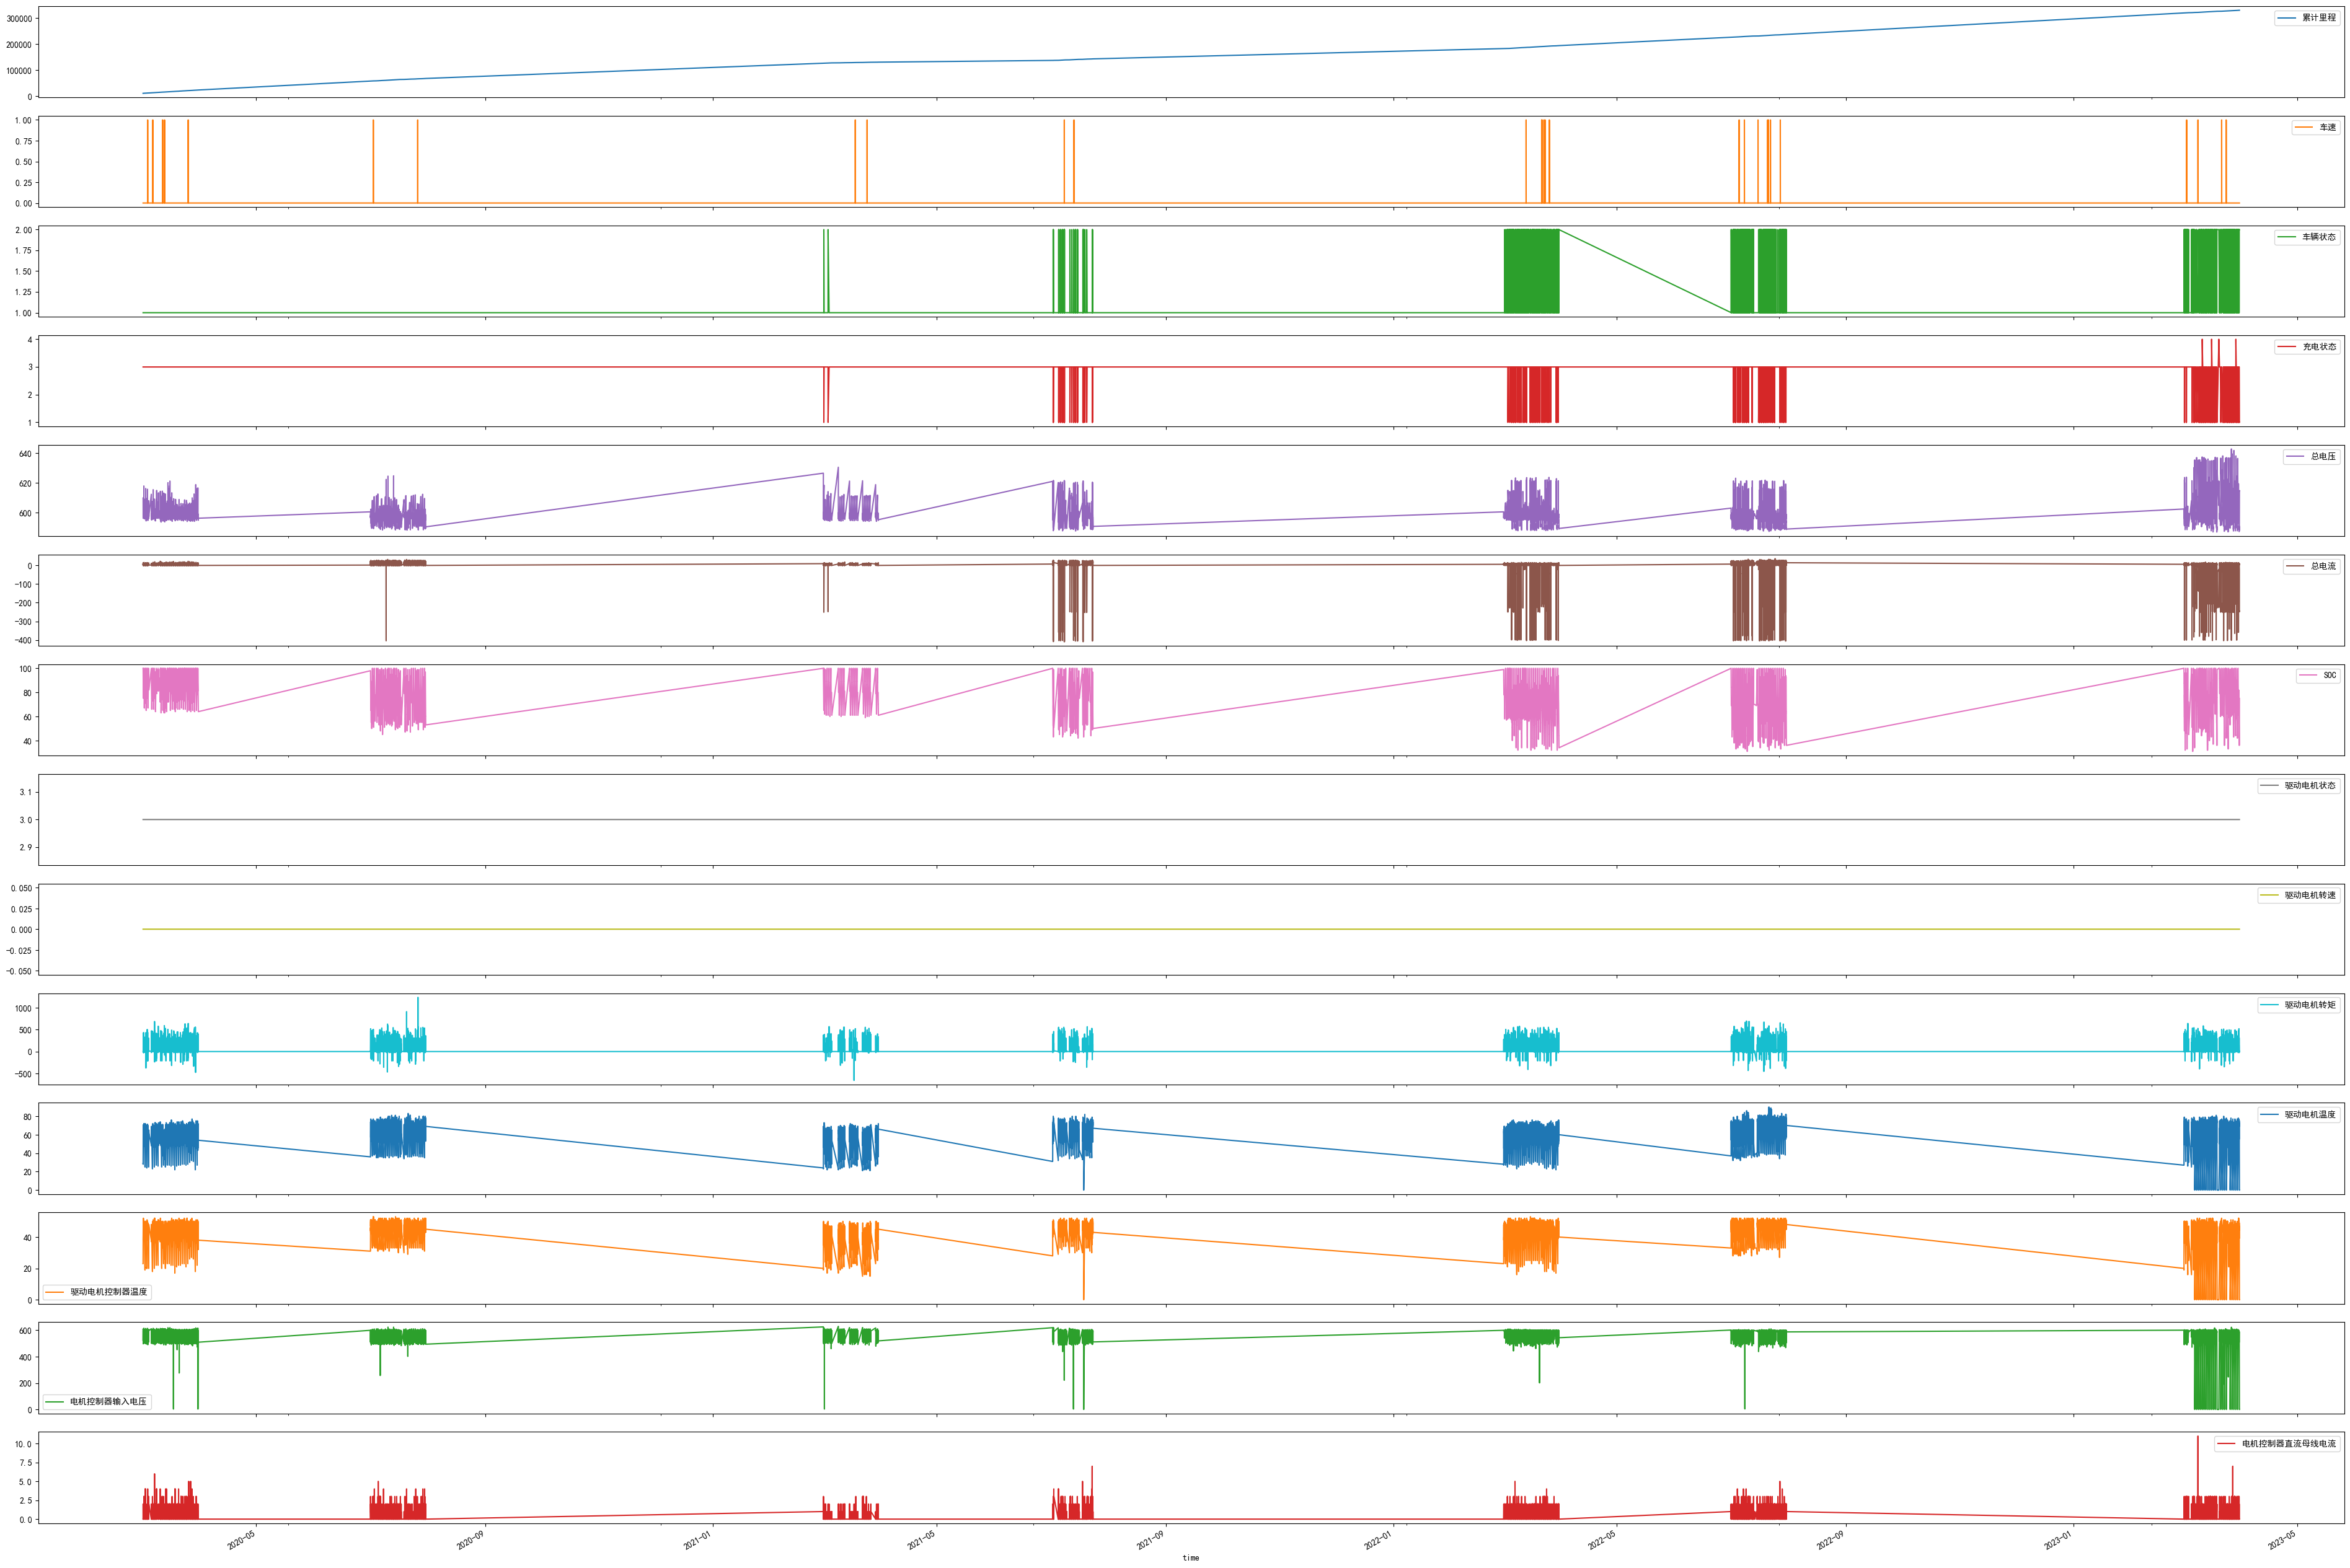

In [63]:
test = deal_data.query('驱动电机状态 == 3')
plot_data_withtime(test,len(test))

## 6.2驱动电机及控制器相关参数

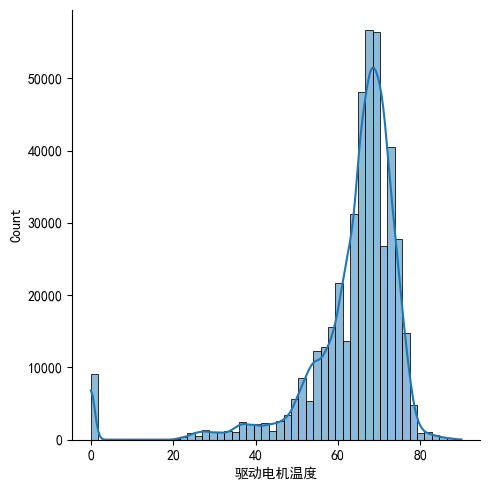

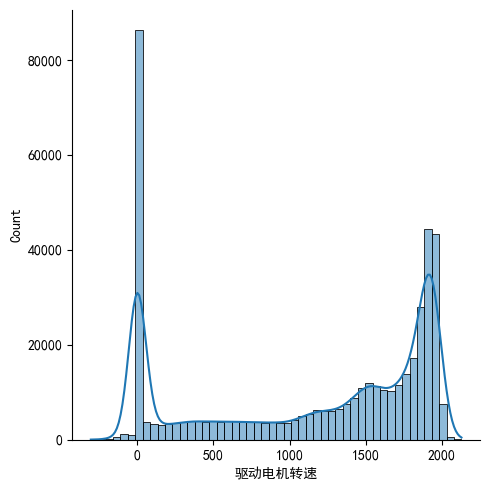

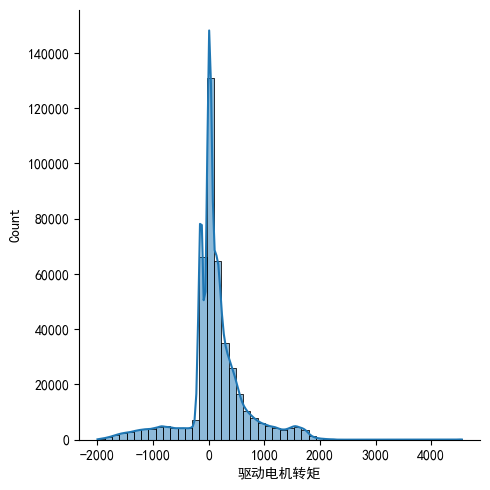

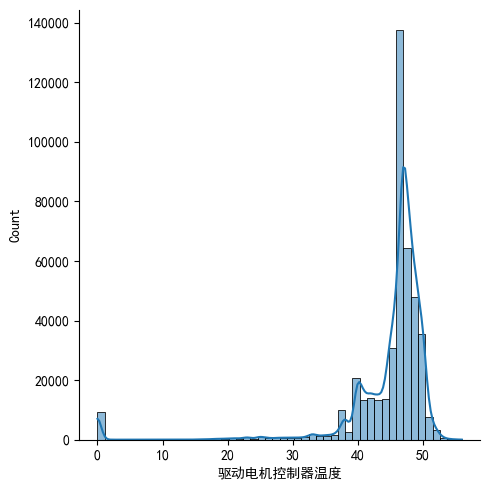

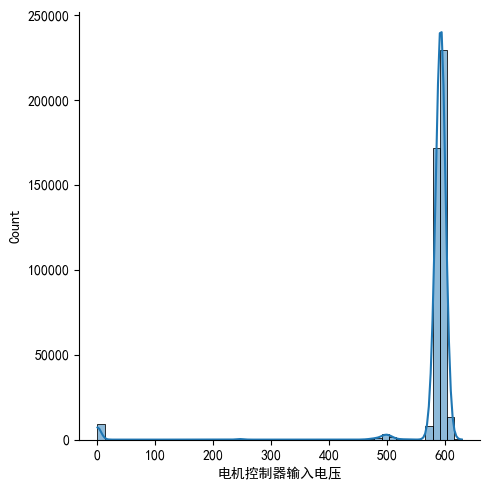

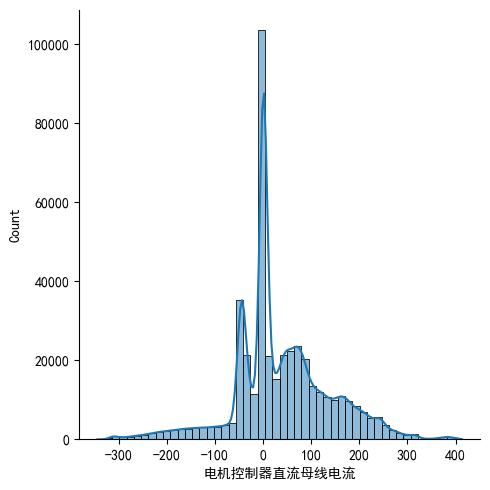

In [64]:
motor_para = ['驱动电机温度', '驱动电机转速', '驱动电机转矩','驱动电机控制器温度', '电机控制器输入电压', '电机控制器直流母线电流']
for i in motor_para:
    sns.displot(deal_data[i], bins=50, kde=True)